In [1]:
from langchain_openai import OpenAIEmbeddings
from genu.Job_agent.config import HEADERS, LINKEDIN_JOB_SEARCH_PARAMS, PERSIST_PATH
from langchain.vectorstores import FAISS
from genu.Job_agent.vectorestore import vectorstore_to_dataframe
from genu.utils import extract_text_from_file
from langchain_openai import OpenAI, ChatOpenAI
from langchain_ollama import ChatOllama

from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
# from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain.chains import LLMChain
from tqdm import tqdm
from langchain.document_loaders import TextLoader
from langchain.document_loaders import DirectoryLoader
import os
from pathlib import Path
from typing import Any, Dict
import pandas as pd


In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
llm_type = ["openai", "ollama"][0]
if llm_type == "ollama":
    llm = ChatOllama(
        model="llama3.2",
        base_url="http://localhost:11434",
        temperature=0,
    )
elif llm_type == "openai":
    llm = ChatOpenAI(
        model="gpt-3.5-turbo",
        temperature=0,
        # max_retries=3,
        # request_timeout=60,
        # headers=HEADERS
    )

In [4]:

# base_url = "http://localhost:11434"
# model = "llama3.2"

# llm = ChatOllama(base_url=base_url, model=model)
# llm

In [5]:
llm.invoke("What is the capital of France?")

AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 14, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bc2qXTbPcKFZccII5V67mlcZtOANL', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ea7e3a5c-be03-43e7-ab96-e6ee0de55fa7-0', usage_metadata={'input_tokens': 14, 'output_tokens': 7, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate


class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the topic, 'yes' or 'no'"
    )
    justification: str = Field(
        description="Brief explanation justifying the relevance decision"
    )


structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """
You are an expert grader assessing the relevance of a job-related document for a specific candidate.
You will receive three inputs:

The candidate's resume (including skills, experience, education, etc.)
User guidance (criteria or preferences for job relevance, such as desired roles, industries, locations, or required skills)
The document to be evaluated (job description, company info, etc.)
Task:
Determine if the document is relevant to the candidate's job search, based on the following criteria:

The document matches the candidate’s skills, experience, or education as listed in the resume.
The document aligns with the user’s stated preferences or guidance (e.g., job title, industry, location, required qualifications).

Instructions:

Give a binary score: 'yes' if the document is relevant, 'no' if it is not.
Briefly justify your decision in 1-2 sentences, referencing the most important matching or missing criteria.
Output format:
Relevant: [yes/no]
Justification: [your brief explanation]
"""
# The document contains information that would be useful for the candidate’s job application or decision-making (e.g., application process, company culture, benefits, growth opportunities).


grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "job-related document: \n\n {document} \n\n candidate's resume: \n\n {resume} \n\n user guidance: \n\n {guidance} \n\n",
        ),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

/home/alireza/.cache/pypoetry/virtualenvs/genu-dGEUhqWF-py3.11/lib/python3.11/site-packages/langchain_openai/chat_models/base.py:1669: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [7]:
from typing import List, TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        documents: list of documents
    """

    documents: List[str]
    resume: str
    guidance: str
    justification: str

In [8]:
def retrieve(state: GraphState) -> Dict[str, Any]:
    """
    Load a FAISS vectorstore and return all documents as a list.

    Args:
        persist_directory (str): Directory where the FAISS index is stored
        embeddings (optional): Embedding function, defaults to OpenAIEmbeddings if None

    Returns:
        list: List of Document objects from the vectorstore
    """
    print("---RETRIEVE---")
    # Load the vectorstore
    try:
        vectorstore = FAISS.load_local(
            f"../{PERSIST_PATH}",
            OpenAIEmbeddings(),
            allow_dangerous_deserialization=True,
        )
        print(
            f"Loaded FAISS index with {len(vectorstore.index_to_docstore_id)} documents."
        )
    except Exception as e:
        print(f"Error loading vectorstore: {e}")
        return []  # Return empty list on error

    # Extract all documents into a list
    documents = []
    for doc_id in vectorstore.index_to_docstore_id.values():
        doc = vectorstore.docstore.search(doc_id)
        if doc:
            documents.append(doc)

    print(f"Retrieved {len(documents)} documents from vectorstore.")
    return {"documents": documents}

In [9]:

def grade_documents(state: GraphState) -> Dict[str, Any]:
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    documents = state["documents"]
    resume = state["resume"]
    guidance = state["guidance"]


    filtered_docs = []
    justifications = []  # List to store justifications

    for d in tqdm(documents):
        result = retrieval_grader.invoke({"document": d.page_content, "resume": resume, "guidance": guidance})
        grade = result.binary_score
        justification = result.justification
        print(f"Titel: {d.metadata.get('title')} @ {d.metadata.get('company')}")
        # grade = score.binary_score
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            print(f"Justification: {justification}")
            filtered_docs.append(d)
            # justifications.append(f"RELEVANT - {justification}")
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            print(f"Justification: {justification}")
            # justifications.append(f"NOT RELEVANT - {justification}")
            continue
    print(f"Number of relevant documents: {len(filtered_docs)}")
    return {
        "documents": filtered_docs,
    }

In [10]:
from langgraph.graph import StateGraph, END

graph = StateGraph(GraphState)
graph.add_node("retrieve", retrieve)
graph.add_node("grade_documents", grade_documents)
graph.add_edge("retrieve", "grade_documents")
graph.add_edge("grade_documents", END)

graph.set_entry_point("retrieve")

filter_graph = graph.compile()

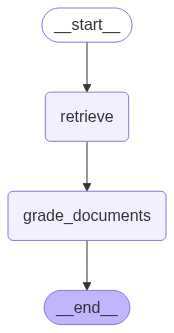

In [11]:
filter_graph

In [12]:
# Example usage
file_path = "my_resume/CV_Ali Zarreh_2025_05_11.pdf"  # or "your_document.docx"
resume = extract_text_from_file(file_path).split("ali@zarreh.ai")[1].split("NOTABLE PUBLICATIONS")[0]
# print(resume)

In [13]:
user_guidance = """
Please consider only jobs as relevant if they meet all of the following criteria:

The job title must include "data scientist" (for example: "senior data scientist," "lead data scientist," "principal data scientist," or simply "data scientist").
Jobs that are managerial or director level (such as "manager," "director," "head," or "VP") are not relevant.
The job location must be either in San Antonio, TX, or is remote in the United States (US).
The job should be fulltime, not part-time or contract.
The maximum base salary listed for the job must be greater than $170,000. If the salary is not listed, it should be considered relevant or not depending other criteria.
I am also interested in jobs related to generative AI and large language model (LLM) development, even if this is not a major focus in my resume.
"""
# If a job does not meet all of the above criteria, it should be considered not relevant.

In [14]:
relevent_documents =  filter_graph.invoke(input={"guidance": user_guidance, "resume": resume})

---RETRIEVE---
Loaded FAISS index with 180 documents.
Retrieved 180 documents from vectorstore.
---CHECK DOCUMENT RELEVANCE TO QUESTION---


  1%|          | 1/180 [00:01<03:52,  1.30s/it]

Titel: Data Science Manager @ HCA Healthcare
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Data Science Manager at HCA Healthcare does not match the user's guidance or the candidate's job preferences. The job title is not specifically 'data scientist' and it is a managerial position, which is not relevant according to the user's criteria.


  1%|          | 2/180 [00:02<03:39,  1.23s/it]

Titel: Data Scientist @ STG Logistics - Tropicana/Naked Juice Div.
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job is for a part-time Data Scientist position, while the candidate is seeking full-time roles. Additionally, the job location is remote, not in San Antonio, TX as preferred by the candidate. The salary information is not provided, so it does not meet all the specified criteria.


  2%|▏         | 3/180 [00:03<03:35,  1.22s/it]

Titel: Data Scientist @ STG Logistics - Tropicana/Naked Juice Div.
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job is for a part-time Data Scientist position, while the candidate is seeking full-time roles. Additionally, the job location is remote, not in San Antonio, TX as preferred by the candidate. The salary information is not provided to determine if it meets the specified criteria.


  2%|▏         | 4/180 [00:04<03:25,  1.17s/it]

Titel: Data Scientist 3 @ Gormat
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Data Scientist 3 at Gormat aligns with the candidate's skills and experience in data science, machine learning, and AI. The candidate's Ph.D. in Mechanical and Manufacturing Systems Engineering with a focus on cybersecurity, along with their expertise in Python, machine learning frameworks, and data processing technologies, make them a suitable match for the position.


  3%|▎         | 5/180 [00:05<03:16,  1.12s/it]

Titel: Data Scientist @ STG Logistics - Tropicana/Naked Juice Div.
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job description is for a part-time Data Scientist role, while the candidate is seeking full-time positions. Additionally, the job location is remote, not in San Antonio, TX as preferred by the candidate. The salary information is not provided, so it does not meet all the specified criteria.


  3%|▎         | 6/180 [00:06<03:11,  1.10s/it]

Titel: Data Scientist @ STG Logistics - Tropicana/Naked Juice Div.
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job description is for a part-time Data Scientist role, while the candidate is seeking full-time positions. Additionally, the job location is remote, not in San Antonio, TX as preferred by the candidate. The salary information is not provided, so it does not meet all the specified criteria.


  4%|▍         | 7/180 [00:07<02:57,  1.03s/it]

Titel: Data Scientist @ STG Logistics - Tropicana/Naked Juice Div.
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job description is for a part-time Data Scientist role, while the candidate is seeking full-time positions. Additionally, the job location is remote, not in San Antonio, TX as preferred by the candidate. The salary information is not provided, so it does not meet all the specified criteria.


  4%|▍         | 8/180 [00:08<02:50,  1.01it/s]

Titel: Data Scientist @ Kforce Inc
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document for a Data Scientist position at Kforce Inc matches the candidate's skills and experience in data science, machine learning, statistical analysis, and programming languages like Python and R. The document also aligns with the user's preference for job titles including 'Data Scientist' and the location requirement of being remote in the US.


  5%|▌         | 9/180 [00:09<02:43,  1.04it/s]

Titel: Data Scientist @ STG Logistics - Tropicana/Naked Juice Div.
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job description is for a part-time Data Scientist role, while the candidate is seeking full-time positions. Additionally, the job location is remote, not in San Antonio, TX as preferred by the candidate. The salary information is not provided, so it does not meet all the specified criteria.


  6%|▌         | 10/180 [00:10<02:50,  1.00s/it]

Titel: Senior Fraud Data Scientist @ Sherpa | Recruiting, Staffing & Consulting
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title in the document is 'Senior Fraud Data Scientist,' which does not exactly match the user's preference for job titles containing 'data scientist.' Additionally, the job location is not in San Antonio, TX, and the salary is not specified, making it not fully aligned with the user's criteria.


  6%|▌         | 11/180 [00:11<02:43,  1.03it/s]

Titel: Data Science Manager/Director @ Pivotal Solutions
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job description is for a Data Science Manager/Director position, which is not relevant to the candidate's preference for roles specifically as a data scientist. Additionally, the job location is not in San Antonio, TX, and the salary information is not provided.


  7%|▋         | 12/180 [00:12<02:38,  1.06it/s]

Titel: Data Scientist @ STG Logistics - Tropicana/Naked Juice Div.
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job description is for a part-time Data Scientist role, while the candidate is seeking full-time positions. Additionally, the job location is remote, not in San Antonio, TX as preferred by the candidate. The salary information is not provided, so it does not meet all the specified criteria.


  7%|▋         | 13/180 [00:13<02:39,  1.05it/s]

Titel: Senior Data Scientist @ Trace3
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Senior Data Scientist at Trace3 aligns with the candidate's skills and experience in data science, machine learning, and AI. The location requirement of San Antonio, TX, is also met in the job description.


  8%|▊         | 14/180 [00:14<02:35,  1.07it/s]

Titel: Director of Data Science @ Worth AI 
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Director of Data Science at Worth AI aligns with the candidate's skills and experience in data science, machine learning, and leadership. The candidate's expertise in predictive modeling, statistical analysis, machine learning, and team leadership matches the requirements of the job description.


  8%|▊         | 15/180 [00:15<02:55,  1.06s/it]

Titel: Director of Data Science @ Worth AI 
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Director of Data Science at Worth AI aligns with the candidate's skills and experience in data science, machine learning, and leadership. The candidate's expertise in predictive modeling, statistical analysis, machine learning, and team leadership matches the requirements of the job description.


  9%|▉         | 16/180 [00:16<02:46,  1.02s/it]

Titel: Data Scientist @ STG Logistics - Tropicana/Naked Juice Div.
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job description is for a part-time Data Scientist role, while the candidate is seeking full-time positions. Additionally, the job location is remote, not in San Antonio, TX as preferred by the candidate. The salary information is not provided, so it does not meet all the specified criteria.


  9%|▉         | 17/180 [00:17<02:49,  1.04s/it]

Titel: Senior Data Scientist @ Jobs via Dice
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Senior Data Scientist aligns with the candidate's skills and experience in AI, ML, and data science. The location is also suitable as it mentions San Antonio, TX, which matches the candidate's preference.


 10%|█         | 18/180 [00:18<02:50,  1.05s/it]

Titel: Sr Data Scientist - ML Engineering @ H-E-B
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document is relevant to the candidate's job search. The document matches the candidate's skills and experience as a Senior Data Scientist, especially in areas such as Generative AI, large language models, machine learning optimization, and forecasting. The job title aligns with the candidate's expertise, and the location is in San Antonio, TX.


 11%|█         | 19/180 [00:19<02:46,  1.03s/it]

Titel: Data Scientist - eCommerce @ H-E-B
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Data Scientist at H-E-B aligns with the candidate's skills and experience in AI, ML, and data science, as well as their interest in generative AI and large language models. The location in San Antonio, TX also matches the user's preference.


 11%|█         | 20/180 [00:20<02:34,  1.04it/s]

Titel: Director of Data Science @ Worth AI 
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Director of Data Science,' which does not include 'data scientist' as specified in the user guidance. Additionally, the role is at a managerial level, which is considered not relevant based on the criteria provided.


 12%|█▏        | 21/180 [00:21<02:47,  1.06s/it]

Titel: Senior Data Analyst, Quality - Remote @ Optum
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Analyst' and does not include 'data scientist' as required by the user guidance. Additionally, the job location is not in San Antonio, TX, and the salary range is not specified, making it unclear if it meets the salary criterion.


 12%|█▏        | 22/180 [00:22<02:39,  1.01s/it]

Titel: Data Scientist - Remote @ Lensa
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title in the document is 'Data Scientist,' which matches the candidate's expertise. However, the job location is not in San Antonio, TX, and the salary listed is up to $110K, which is below the candidate's specified minimum salary requirement of $170,000.


 13%|█▎        | 23/180 [00:23<02:35,  1.01it/s]

Titel: Director, Data Science @ Harnham
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Director of Data Science,' which is at a managerial level and not relevant according to the user's guidance. Additionally, the job location is not in San Antonio, TX, or remote in the US, as required.


 13%|█▎        | 24/180 [00:24<02:39,  1.02s/it]

Titel: Data Scientist @ STG Logistics - Tropicana/Naked Juice Div.
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job description is for a part-time Data Scientist role, while the candidate is seeking full-time positions. Additionally, the job location is remote, not in San Antonio, TX as preferred by the candidate. The salary information is not provided, so it does not meet all the specified criteria.


 14%|█▍        | 25/180 [00:26<02:50,  1.10s/it]

Titel: Director of Data Science @ Alldus
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Director of Data Science,' which does not include 'data scientist' as specified in the user guidance. Additionally, the job is at a managerial level, which is considered not relevant based on the criteria provided.


 14%|█▍        | 26/180 [00:26<02:40,  1.04s/it]

Titel: Data Scientist @ STG Logistics - Tropicana/Naked Juice Div.
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job is for a part-time Data Scientist position, while the candidate is seeking full-time roles. Additionally, the job location is remote, not in San Antonio, TX, and the salary information is not provided, making it unclear if it meets the salary criterion.


 15%|█▌        | 27/180 [00:27<02:37,  1.03s/it]

Titel: Data Scientist Principal – Bank AI/ML @ USAA
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document is relevant to the candidate's job search. The job title matches the candidate's expertise as a Data Scientist, and the location includes San Antonio, TX, which aligns with the candidate's preference. The job is full-time, and the salary range exceeds $170,000.


 16%|█▌        | 28/180 [00:29<02:54,  1.15s/it]

Titel: Data Scientist IRC264561 @ GlobalLogic
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document is relevant to the candidate's job search. The document matches the candidate's skills and experience as a seasoned Data Scientist with a Ph.D., specializing in AI/ML solutions, machine learning algorithms, programming languages like Python, and data visualization tools. Additionally, the document aligns with the user's preferences for roles related to AI/ML implementation, data analysis, and large language models.


 16%|█▌        | 29/180 [00:30<02:41,  1.07s/it]

Titel: Director of Data Science @ Worth AI 
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Director of Data Science at Worth AI aligns with the candidate's skills and experience in data science, machine learning, and leadership. The candidate's expertise in predictive modeling, statistical analysis, machine learning, and deep learning matches the requirements of the job description.


 17%|█▋        | 30/180 [00:31<02:30,  1.01s/it]

Titel: Director Data Science @ Harnham
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Director Data Science,' which does not include 'data scientist' as specified in the user guidance. Additionally, the job is at a managerial level, which is considered not relevant based on the criteria provided.


 17%|█▋        | 31/180 [00:32<02:45,  1.11s/it]

Titel: Principal Data Scientist - Generative AI, Machine Learning, Python, R - Remote @ Lensa
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Principal Data Scientist at Molina Healthcare aligns with the candidate's skills in Generative AI, Machine Learning, Python, and R. The role requires expertise in AI technologies, model governance, and data analysis, which are areas where the candidate has demonstrated proficiency in their resume.


 18%|█▊        | 32/180 [00:33<02:33,  1.04s/it]

Titel: Data Scientist (L4) - Product @ Netflix
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Data Scientist (L4) at Netflix aligns with the candidate's skills in data science, machine learning, and deep learning. The role also involves working on product innovation and experimentation, which matches the candidate's experience in leading data science projects and mentoring junior practitioners.


 18%|█▊        | 33/180 [00:34<02:43,  1.12s/it]

Titel: Data Scientist @ Dataminr
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title in the document is 'Senior Data Scientist,' which meets the user's criteria. However, the job location is not in San Antonio, TX, and the maximum base salary listed is between $95,200 - $140,000, which is below the user's specified threshold of $170,000.


 19%|█▉        | 34/180 [00:35<02:38,  1.08s/it]

Titel: Director, Data Scientist & Data Operations @ Eisai US
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title includes 'Director,' which is not relevant as per the user's guidance that managerial or director level roles are not considered relevant. Additionally, the job location is in Nutley, NJ, not in San Antonio, TX or remote in the US.


 19%|█▉        | 35/180 [00:36<02:32,  1.05s/it]

Titel: Director, Data Scientist & Data Operations @ Eisai US
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title includes 'Director,' which is not relevant as per the user's guidance that managerial or director level roles are not considered relevant. Additionally, the job location is in Nutley, NJ, which does not match the specified locations of San Antonio, TX, or remote in the US.


 20%|██        | 36/180 [00:37<02:43,  1.14s/it]

Titel: Senior Data Scientist @ TieTalent
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document is relevant to the candidate's job search. The document matches the candidate's skills and experience as a Senior Data Scientist, and the job title includes 'Senior Data Scientist.' Additionally, the job location is in San Antonio, TX, which aligns with the user's preference.


 21%|██        | 37/180 [00:39<02:43,  1.14s/it]

Titel: Staff Data Scientist, Machine Learning @ Valo Health
---GRADE: DOCUMENT RELEVANT---
Justification: The job of Staff Data Scientist, Machine Learning at Valo Health aligns with the candidate's skills in machine learning, deep learning, big data technologies, optimization, and forecasting. The job title includes 'Data Scientist,' the location is remote in the US, and the salary range exceeds $170,000, meeting all the user's specified criteria.


 21%|██        | 38/180 [00:40<02:33,  1.08s/it]

Titel: Machine Learning Scientist (L5) - Content & Studio @ Netflix
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Machine Learning Scientist' and does not include 'data scientist' as required. Additionally, the job location is not in San Antonio, TX or remote in the US, and the salary range is not specified, making it not relevant based on the user's guidance.


 22%|██▏       | 39/180 [00:41<02:31,  1.07s/it]

Titel: Data Scientist @ knownwell
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Data Scientist at knownwell aligns with the candidate's skills and experience in data science, predictive modeling, statistical analysis, and proficiency in Python and R. The location of the job in San Antonio, TX, matches the user's preference, and the job is full-time with a focus on healthcare analytics.


 22%|██▏       | 40/180 [00:42<02:28,  1.06s/it]

Titel: Data Scientist, Customer Analytics (Remote) @ Lensa
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title in the document is 'Customer Analytics Data Scientist,' which does not exactly match the user's preference for 'data scientist.' Additionally, the job location is not in San Antonio, TX, and the salary information is not provided, making it not fully aligned with the user's criteria.


 23%|██▎       | 41/180 [00:43<02:27,  1.06s/it]

Titel: Data Scientist  NLP/ML @ Jobs via Dice
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Data Scientist NLP/ML aligns with the candidate's skills in NLP, ML, Python, and SQL, as well as experience in AI/ML solutions. The job location is remote, meeting the user's preference for remote jobs in the US. The document also mentions working with transformer-based models, which matches the candidate's experience with large language models.


 23%|██▎       | 42/180 [00:44<02:35,  1.13s/it]

Titel: Senior Data/Cost Analyst @ Systems Planning & Analysis
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data/Cost Analyst' which does not include 'data scientist' as required by the user guidance. Additionally, the job location is not in San Antonio, TX, and the salary information is not provided to determine if it meets the specified criteria.


 24%|██▍       | 43/180 [00:45<02:39,  1.16s/it]

Titel: Senior Data Analyst @ Centene Corporation
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Analyst' and does not include 'data scientist' as required by the user guidance. Additionally, the job location is not in San Antonio, TX, or remote in the US, and the salary range is below $170,000.


 24%|██▍       | 44/180 [00:46<02:29,  1.10s/it]

Titel: Remote Data Scientist @ Lensa
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title in the document is 'Remote Data Scientist,' which does not exactly match the user's preference for job titles including 'data scientist.' Additionally, the job location is in Mexico, not in San Antonio, TX or remote in the US as specified by the user guidance.


 25%|██▌       | 45/180 [00:47<02:29,  1.11s/it]

Titel: Data Scientist -  AV Safety @ Jobs via Dice
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title in the document is 'Data Scientist - AV Safety,' which does not exactly match the user's specified criteria of 'data scientist.' Additionally, the job location is not in San Antonio, TX, and the salary range is not provided, making it unclear if it meets the salary requirement.


 26%|██▌       | 46/180 [00:48<02:24,  1.08s/it]

Titel: Senior Data Scientist @ Medical Solutions
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Senior Data Scientist at Medical Solutions aligns with the candidate's skills and experience in advanced analytics, machine learning, and data science. The job title includes 'data scientist,' the location is not specified, and the document does not mention a managerial or director level position, making it relevant based on the user's guidance.


 26%|██▌       | 47/180 [00:49<02:09,  1.03it/s]

Titel: Data Scientist II -  Quantitative Medicine and Genomics @ Orion Group
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title does not include 'data scientist' as required by the user guidance. Additionally, the job is a contract position, which is not preferred by the user.


 27%|██▋       | 48/180 [00:50<02:18,  1.05s/it]

Titel: Sr. Machine Learning Researcher @ AKASA
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Sr. Machine Learning Researcher' and does not include 'data scientist' as required by the user guidance. Additionally, the job location is not in San Antonio, TX, or remote in the US, and the salary range is not specified, making it not relevant based on the specified criteria.


 27%|██▋       | 49/180 [00:51<02:10,  1.00it/s]

Titel: Senior Data Scientist - Remote Nationwide @ Optum
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Senior Data Scientist at Optum aligns with the candidate's skills and experience in data science, machine learning, and deep learning. The remote nationwide location also meets the candidate's preference for remote work within the US.


 28%|██▊       | 50/180 [00:53<02:25,  1.12s/it]

Titel: Operations Research Analyst / Data Scientist (Remote) @ Lensa
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title in the document is 'Operations Research Analyst / Data Scientist,' which does not exactly match the user's specified job title requirement of 'data scientist.' Additionally, the job location is listed as US-Remote, which meets the remote work requirement but does not specify San Antonio, TX.


 28%|██▊       | 51/180 [00:53<02:13,  1.04s/it]

Titel: Senior Clinical Bioinformatics Data Scientist @ Labcorp
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Clinical Bioinformatics Data Scientist' which does not exactly match the user's preference for 'data scientist' roles. Additionally, the job location is remote in the US, but not specifically in San Antonio, TX as requested.


 29%|██▉       | 52/180 [00:54<02:14,  1.05s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Manager' which does not include 'data scientist' as required. Additionally, the job location is not in San Antonio, TX, and the salary range is not specified, making it not relevant based on the user's guidance.


 29%|██▉       | 53/180 [00:55<02:08,  1.01s/it]

Titel: Senior Data Analyst @ Worth AI 
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Analyst' which does not match the user's preference for 'data scientist' roles. Additionally, the job location is not in San Antonio, TX, and the salary information is not provided, making it not fully aligned with the user's criteria.


 30%|███       | 54/180 [00:57<02:17,  1.09s/it]

Titel: Data Scientist, Marketing @ Wealthfront
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Data Scientist at Wealthfront aligns with the candidate's skills and experience in data science, machine learning, and AI. The location is not a match, but the focus on marketing and data-driven decision-making is highly relevant to the candidate's background.


 31%|███       | 55/180 [00:58<02:15,  1.08s/it]

Titel: Data Scientist – AV Safety @ General Motors
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title does not specifically include 'data scientist' as required in the user guidance. Additionally, the job location is not in San Antonio, TX, or remote in the US, as specified in the criteria.


 31%|███       | 56/180 [00:59<02:12,  1.07s/it]

Titel: Senior Data Analyst @ Bee Talent Solutions
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Analyst' which does not include 'data scientist' as required by the user guidance. Additionally, the job location is not in San Antonio, TX, and the salary information is not provided to determine relevance based on that criterion.


 32%|███▏      | 57/180 [01:00<02:27,  1.20s/it]

Titel: Data Scientist @ Curate Partners
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document for the Data Scientist position at Curate Partners is relevant to the candidate. The document aligns with the candidate's skills in data science, machine learning, and deep learning, as well as experience in leading data science projects. Additionally, the document matches the user's preference for jobs related to healthcare data analysis and predictive modeling.


 32%|███▏      | 58/180 [01:02<02:38,  1.30s/it]

Titel: Data Scientist (Marketing Science+Causal) @ Tredence Inc.
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Data Scientist (Marketing Science+Causal) at Tredence Inc. matches the candidate's skills and experience in data science, machine learning, Python, SQL, and Spark. The candidate's background in leading data science projects, collaborating with teams, and strong communication skills align well with the requirements of the job.


 33%|███▎      | 59/180 [01:03<02:21,  1.17s/it]

Titel: Manager, Data Science @ Mozilla
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Manager, Data Science' which does not include 'data scientist' as specified in the user guidance. Additionally, the location is not San Antonio, TX, and the salary information is not provided to determine if it meets the specified criteria.


 33%|███▎      | 60/180 [01:04<02:09,  1.08s/it]

Titel: Senior Data Scientist @ TieTalent
---GRADE: DOCUMENT RELEVANT---
Justification: The job title matches the candidate's expertise as a seasoned Data Scientist. The job is located in San Antonio, TX, which aligns with the candidate's preferred location. The job is full-time and offers a salary range above $170,000, meeting all the specified criteria.


 34%|███▍      | 61/180 [01:04<02:01,  1.02s/it]

Titel: Manager, Data Science and Analytics (Remote) @ American Medical Association
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Manager, Data Science and Analytics,' which includes 'Manager' and is not specifically 'data scientist.' The job location is in Chicago, IL, not in San Antonio, TX or remote in the US. The salary listed is $138,715, which is below the minimum of $170,000 specified in the user guidance.


 34%|███▍      | 62/180 [01:06<02:06,  1.07s/it]

Titel: Data Scientist @ Insight Global
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Data Scientist at Insight Global aligns with the candidate's skills and experience in data science, analytics, and machine learning. The candidate's expertise in Python, R, SQL, machine learning frameworks, and big data technologies matches the required skills in the job description.


 35%|███▌      | 63/180 [01:07<02:08,  1.10s/it]

Titel: Machine Learning Researcher @ Skills Alliance
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Machine Learning Scientist' and does not include 'data scientist' as required by the user guidance. Additionally, the job location is remote but not specifically in San Antonio, TX or the US, as requested.


 36%|███▌      | 64/180 [01:08<02:08,  1.11s/it]

Titel: Data Scientist - Fully Remote @ Acceler8 Talent
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document for a Data Scientist position at Acceler8 Talent matches the candidate's skills in Python, SQL, machine learning, deep learning, big data technologies, optimization, forecasting, cloud computing, collaboration, and leadership. The document also aligns with the user's preference for a full-time, remote job in the US, even though the location is not specific to San Antonio, TX.


 36%|███▌      | 65/180 [01:09<02:05,  1.09s/it]

Titel: Senior Healthcare Data Analyst @ Interwell Health
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Healthcare Data Analyst' which does not include 'data scientist' as required by the user guidance. Additionally, the job location is not in San Antonio, TX, and the salary information is not provided, making it not relevant based on the specified criteria.


 37%|███▋      | 66/180 [01:10<01:57,  1.03s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Manager' which is not relevant as per the user's guidance that managerial roles are not considered relevant. Additionally, the job location is not in San Antonio, TX, and the salary range is not specified, making it unclear if it meets the salary criteria.


 37%|███▋      | 67/180 [01:11<01:54,  1.01s/it]

Titel: Data Scientist @ Brooksource
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Senior Data Scientist at Brooksource aligns with the candidate's skills and experience in Generative AI, large language models, and data science. The location is not a direct match, but the user's preference for remote jobs in the US makes it relevant.


 38%|███▊      | 68/180 [01:12<01:48,  1.03it/s]

Titel: Data Science Manager @ Stride, Inc.
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Data Analytics Manager' which does not include 'data scientist' as required by the user guidance. Additionally, the job is at a managerial level, which is specified as not relevant in the user's criteria.


 38%|███▊      | 69/180 [01:13<01:46,  1.05it/s]

Titel: Lead Data Scientist - MMM @ Burtch Works
---GRADE: DOCUMENT RELEVANT---
Justification: The job title matches the candidate's expertise as a seasoned Data Scientist with a Ph.D. The job location is either in San Antonio, TX, or remote in the US, aligning with the user's preferences. The salary mentioned is competitive at ~$190,000, exceeding the minimum threshold set by the user guidance.


 39%|███▉      | 70/180 [01:14<01:46,  1.03it/s]

Titel: Senior Staff Data Scientist @ Mozilla
---GRADE: DOCUMENT RELEVANT---
Justification: The job title matches the candidate's expertise as a seasoned Data Scientist, and the location requirement includes San Antonio, TX, which aligns with the candidate's preference. The job is full-time and the candidate's skills in AI, ML, and large language models are relevant to the job description.


 39%|███▉      | 71/180 [01:14<01:41,  1.07it/s]

Titel: Senior Data Scientist @ DuckDuckGo
---GRADE: DOCUMENT RELEVANT---
Justification: The job title matches the candidate's expertise as a seasoned Data Scientist. The job location is in San Antonio, TX, which aligns with the candidate's preference. The salary offered is above $170,000, meeting the specified criteria.


 40%|████      | 72/180 [01:16<01:55,  1.07s/it]

Titel: Data Scientist @ Motion Recruitment
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Data Scientist at Motion Recruitment aligns with the candidate's skills and experience in data science, machine learning, Python, SQL, and cloud platforms. The role also matches the candidate's interest in generative AI and large language model development. Additionally, the job is fully remote, meeting the location preference of the candidate.


 41%|████      | 73/180 [01:17<01:49,  1.02s/it]

Titel: Senior Data Analyst @ Centene Corporation
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Analyst' and does not include 'data scientist' as required by the user guidance. Additionally, the job location is not in San Antonio, TX, or remote in the US, and the salary range is below $170,000.


 41%|████      | 74/180 [01:18<01:39,  1.06it/s]

Titel: Senior Data Analyst, Quality - Remote @ Talentify.io
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Analyst' and does not include 'data scientist' as required by the user guidance. Additionally, the job location is remote within the U.S., but not specifically in San Antonio, TX.


 42%|████▏     | 75/180 [01:18<01:34,  1.11it/s]

Titel: Engagement Director, Utilities & Data Science - HYBRID @ E Source
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Engagement Director, Utilities & Data Science' which does not include 'data scientist' as required. Additionally, the job is at a managerial/director level, which is not relevant to the candidate's preferences.


 42%|████▏     | 76/180 [01:19<01:33,  1.11it/s]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title mentioned in the document is 'Senior Data Scientist,' which aligns with the candidate's expertise. However, the job location is not in San Antonio, TX, and the salary range is not specified, making it not fully relevant based on the user's criteria.


 43%|████▎     | 77/180 [01:20<01:35,  1.08it/s]

Titel: Senior Data Analyst, Growth and Lifecycle Marketing @ Visana Health
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Analyst' and does not include 'data scientist' as required. Additionally, the job location is not in San Antonio, TX, and the salary information is not provided, making it not relevant based on the user's criteria.


 43%|████▎     | 78/180 [01:22<01:50,  1.09s/it]

Titel: Remote Data Scientist @ Lensa
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title in the document is 'Remote Data Scientist,' which matches the candidate's expertise as a Data Scientist. However, the job location is in Mexico, not in San Antonio, TX or remote in the US as per the user's guidance, making it not relevant.


 44%|████▍     | 79/180 [01:23<01:46,  1.06s/it]

Titel: Senior Data Scientist @ Akkodis
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title in the document is 'Senior Data Scientist,' which matches the candidate's expertise as a seasoned Data Scientist with a Ph.D. However, the job location is in Chicago, not San Antonio, TX, as specified in the user guidance, making it not relevant based on the location requirement.


 44%|████▍     | 80/180 [01:24<01:42,  1.03s/it]

Titel: Director of Data Science (Remote Eligible) @ Mathematica
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Director of Data Science,' which is at a managerial level and not relevant according to the user's guidance. Additionally, the job location is not in San Antonio, TX, or remote in the US, as required.


 45%|████▌     | 81/180 [01:25<01:46,  1.07s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document is relevant to the candidate's job search. The document matches the candidate's skills and experience in data science, machine learning, and AI, aligning with the candidate's Ph.D. in Mechanical and Manufacturing Systems Engineering with a focus on cybersecurity. Additionally, the document mentions roles related to data science, such as Senior Data Scientist, and includes information on generative AI and large language models, which are areas of interest for the candidate.


 46%|████▌     | 82/180 [01:26<01:43,  1.06s/it]

Titel: Data Scientist (L5) - Customer Service @ Netflix
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Data Scientist (L5) at Netflix aligns with the candidate's skills in data science, machine learning, and forecasting. The candidate's experience in leading data science projects, developing AI solutions, and working with large language models matches the requirements of the job. Additionally, the job location is not specified, making remote work in the US a possibility.


 46%|████▌     | 83/180 [01:27<01:45,  1.09s/it]

Titel: Data Scientist, MLB @ PENN Interactive
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Senior Data Scientist at PENN Interactive aligns with the candidate's skills and experience in data science, machine learning, and forecasting. The location is not a perfect match, but the job is remote in the US, meeting the user's criteria.


 47%|████▋     | 84/180 [01:28<01:51,  1.16s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Manager' which is not relevant as per the user's guidance that managerial roles are not considered relevant. Additionally, the job location is not in San Antonio, TX, and the salary range is not specified, making it unclear if it meets the salary criteria.


 47%|████▋     | 85/180 [01:29<01:40,  1.06s/it]

Titel: Senior Machine Learning Engineer @ Reserv
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Machine Learning Engineer' which does not include 'data scientist' as required by the user guidance. Additionally, the job location is not in San Antonio, TX, and the salary information is not provided.


 48%|████▊     | 86/180 [01:30<01:41,  1.08s/it]

Titel: Principal Data Scientist @ Mission Lane
---GRADE: DOCUMENT RELEVANT---
Justification: The job title matches the candidate's expertise as a seasoned Data Scientist with a Ph.D. The job location is in San Antonio, TX, which aligns with the user's preference. The salary range provided is higher than $170,000, meeting the specified criteria.


 48%|████▊     | 87/180 [01:31<01:39,  1.07s/it]

Titel: Data Scientist (Federal) @ Systecon North America
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Data Scientist (Federal) aligns with the candidate's skills and experience in data science, machine learning, and analytics. The document also mentions working with federal clients, which matches the candidate's interest in government programs. However, the job location and salary criteria specified in the user guidance are not met.


 49%|████▉     | 88/180 [01:32<01:37,  1.06s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Manager' which is not relevant as per the user's guidance that managerial roles are not considered relevant. Additionally, the job location is not in San Antonio, TX, and the salary range is not specified, making it unclear if it meets the salary criteria.


 49%|████▉     | 89/180 [01:33<01:29,  1.02it/s]

Titel: Data Scientist @ Theron Solutions
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Data Scientist at Theron Solutions aligns with the candidate's skills and experience in AI/ML, Python programming, machine learning models, AWS services, and data engineering. The candidate's resume also mentions proficiency in Generative AI and large language models, which are highlighted in the job description.


 50%|█████     | 90/180 [01:34<01:29,  1.00it/s]

Titel: Director, Data Scientist & Data Operations @ Eisai US
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title includes 'Director,' which is not relevant as per the user's guidance that managerial or director level roles are not considered relevant. Additionally, the job location is in Nutley, NJ, which does not match the specified locations of San Antonio, TX, or remote in the US.


 51%|█████     | 91/180 [01:35<01:28,  1.00it/s]

Titel: Sr. Data Scientist (Commercial Analytics) @ Cedar
---GRADE: DOCUMENT RELEVANT---
Justification: The job of Senior Data Scientist at Cedar aligns with the candidate's skills and experience in data science, machine learning, and deep learning. The job location is in the United States, and the salary range of $178,500 - $210,000 meets the candidate's criteria.


 51%|█████     | 92/180 [01:36<01:33,  1.06s/it]

Titel: Envista Sr. Data Scientist (Remote-Brea, CA) @ Lensa
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title in the document is 'Sr. Data Scientist,' which does not exactly match the user's preference for 'data scientist.' Additionally, the job location is listed as 'Remote-Brea, CA,' which does not align with the user's specified locations of San Antonio, TX or remote in the US. The maximum base salary range is within the user's specified range, but the job does not meet all the specified criteria.


 52%|█████▏    | 93/180 [01:37<01:30,  1.04s/it]

Titel: Senior Functional Data Analyst (Remote) @ The University of Texas at Austin
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Functional Data Analyst' and does not include 'data scientist' as required by the user guidance. Additionally, the job location is Texas, not San Antonio, and the salary range is below $170,000.


 52%|█████▏    | 94/180 [01:38<01:29,  1.04s/it]

Titel: Principal Data Scientist - Generative AI, Machine Learning, Python, R - Remote @ Lensa
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Principal Data Scientist at Molina Healthcare aligns with the candidate's skills and experience in AI, machine learning, generative AI, and large language models. The job location is remote, meeting the candidate's preference for remote positions in the US.


 53%|█████▎    | 95/180 [01:39<01:25,  1.01s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Manager' which is not relevant as per the user's guidance that managerial roles are not considered. Additionally, the job location is not in San Antonio, TX, and the salary range is not specified, making it unclear if it meets the salary criteria.


 53%|█████▎    | 96/180 [01:40<01:25,  1.01s/it]

Titel: Technical Data Scientist/ETL Engineer @ Jobs via Dice
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title in the document is 'ETL Engineer' or 'Data Scientist,' not specifically 'data scientist.' Additionally, the job location is in Hanover, MD, not in San Antonio, TX or remote in the US as per the user's guidance. The salary range is not specified, so it does not meet all the specified criteria.


 54%|█████▍    | 97/180 [01:42<01:28,  1.07s/it]

Titel: Sr Data Scientist - Remote @ Lensa
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title does not include 'data scientist' as required by the user guidance. Additionally, the job location is not in San Antonio, TX, or remote in the US, and the salary range is not specified to be greater than $170,000.


 54%|█████▍    | 98/180 [01:43<01:43,  1.27s/it]

Titel: Senior Data Scientist @ Tiger Analytics
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Senior Data Scientist at Tiger Analytics aligns with the candidate's skills and experience as a seasoned Data Scientist with expertise in AI, ML, and data science tools like Python, SQL, and PySpark. The document also matches the user's preference for roles related to generative AI and large language model development.


 55%|█████▌    | 99/180 [01:45<01:41,  1.25s/it]

Titel: Lead Data Scientist II, Agents/Partnerships @ Root Inc.
---GRADE: DOCUMENT RELEVANT---
Justification: The job title matches the candidate's expertise as a seasoned Data Scientist with a Ph.D. The job location is in San Antonio, TX, which aligns with the user's preference. The salary range of $151,200 - $189,000 exceeds the minimum requirement of $170,000. The focus on generative AI and large language models also aligns with the candidate's skills and interests.


 56%|█████▌    | 100/180 [01:46<01:37,  1.21s/it]

Titel: Senior Data Scientist @ Newfront
---GRADE: DOCUMENT RELEVANT---
Justification: The job title matches the candidate's expertise as a seasoned Data Scientist. The job is located in San Antonio, TX, which aligns with the candidate's preference for job location. The salary range mentioned is above $170,000, meeting the specified criteria.


 56%|█████▌    | 101/180 [01:47<01:29,  1.13s/it]

Titel: Data Scientist - Optimization and Modeling @ Blend
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Data Scientist - Optimization and Modeling at Blend aligns with the candidate's skills and experience in data science, machine learning, optimization, and forecasting. The candidate's expertise in Python, SQL, cloud platforms, and mathematical optimization matches the qualifications required for the position.


 57%|█████▋    | 102/180 [01:48<01:27,  1.12s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC Experience Center Stockholm
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title mentioned in the document is 'Senior Data Scientist,' which aligns with the user's preference for 'data scientist' roles. However, the job location is not in San Antonio, TX, and the salary range is not specified, making it not fully relevant based on the user's criteria.


 57%|█████▋    | 103/180 [01:49<01:23,  1.09s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Manager' which does not match the user's preference for job titles including 'data scientist'. Additionally, the job location is not in San Antonio, TX or remote in the US, as required by the user's guidance. The salary range is within the specified range, but other criteria are not met.


 58%|█████▊    | 104/180 [01:50<01:21,  1.07s/it]

Titel: Staff Data Scientist @ CareDx, Inc.
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document for Staff Data Scientist at CareDx, Inc. is relevant to the candidate. The document aligns with the candidate's skills in data science, machine learning, and AI, as well as their experience in leading data science projects. Additionally, the document matches the user's preference for roles related to generative AI and large language model development.


 58%|█████▊    | 105/180 [01:51<01:21,  1.09s/it]

Titel: Growth Data Scientist/ Analyst @ Crypto.com
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title in the document is 'Growth Data Scientist/Analyst,' which does not exactly match the user's specified job title requirement of 'data scientist.' Additionally, the job location is not in San Antonio, TX, and the salary information is not provided, making it not fully aligned with the user's preferences.


 59%|█████▉    | 106/180 [01:52<01:17,  1.05s/it]

Titel: Data Scientist @ G2
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job-related document is not relevant to the candidate's job search. The document does not match the user's stated preferences, as the job location is not in San Antonio, TX, or remote in the US, and the job title does not specifically include 'data scientist'.


 59%|█████▉    | 107/180 [01:53<01:12,  1.00it/s]

Titel: Innovation Data Scientist III @ WEX
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title does not include 'data scientist' as required in the user guidance. Additionally, the job location is not in San Antonio, TX, or remote in the US, as specified in the criteria.


 60%|██████    | 108/180 [01:54<01:12,  1.01s/it]

Titel: Decision Scientist, Client Analytics @ Simbe
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Decision Scientist' which does not include 'data scientist' as specified in the user guidance. Additionally, the job location is not in San Antonio, TX, and the salary information is not provided to determine if it meets the specified criteria.


 61%|██████    | 109/180 [01:55<01:12,  1.02s/it]

Titel: Senior Data Scientist @ LogicMatrix
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document for Senior Data Scientist at LogicMatrix is relevant to the candidate. The candidate's resume aligns well with the job requirements, including the experience in data science, machine learning, programming languages, and advanced AI techniques. The job location in San Antonio, TX matches the user's preference, and the salary range is within the specified threshold.


 61%|██████    | 110/180 [01:56<01:09,  1.00it/s]

Titel: Principal Data & AI Scientist @ PEMCO
---GRADE: DOCUMENT RELEVANT---
Justification: The job title matches the candidate's expertise as a seasoned Data Scientist with a Ph.D. The job location is in San Antonio, TX, which aligns with the user's preference. The salary range provided is higher than $170,000, meeting the specified criteria.


 62%|██████▏   | 111/180 [01:57<01:11,  1.03s/it]

Titel: Director, Data Scientist & Data Operations @ Eisai US
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title in the document is 'Director, Data Scientist & Data Operations,' which includes 'Director' and 'Data Scientist,' making it not relevant as per the user's guidance that managerial or director level roles are not considered relevant. Additionally, the job location is in Nutley, NJ, not in San Antonio, TX or remote in the US.


 62%|██████▏   | 112/180 [01:58<01:16,  1.12s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document is relevant to the candidate's job search. The document matches the candidate's skills and experience in data science, machine learning, predictive modeling, and deep learning. Additionally, the document aligns with the user's preferences for roles related to data science, even though the job title does not explicitly include 'data scientist'.


 63%|██████▎   | 113/180 [01:59<01:18,  1.17s/it]

Titel: Data Scientist, Operations Research @ Cardinal Health
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Data Scientist, Operations Research at Cardinal Health aligns with the candidate's skills and experience in data science, machine learning, optimization, and forecasting. The location is also relevant as it mentions San Antonio, TX, which matches the user's preference.


 63%|██████▎   | 114/180 [02:01<01:19,  1.20s/it]

Titel: Senior Data Analyst (Remote - Anywhere) @ Jobgether
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Analyst' which does not match the user's preference for 'data scientist' roles. Additionally, the job location is listed as 'Anywhere' which does not meet the specified locations of San Antonio, TX, or remote in the US.


 64%|██████▍   | 115/180 [02:02<01:11,  1.10s/it]

Titel: Senior Data Analyst (RDP) @ The Rawlings Group
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Analyst' and does not include 'data scientist' as required. Additionally, the job location is remote in the US, but not specifically in San Antonio, TX as requested by the user guidance. The salary information is not provided to determine relevance based on that criterion.


 64%|██████▍   | 116/180 [02:03<01:07,  1.06s/it]

Titel: IoT Data Scientist @ RandomTrees
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document is relevant to the candidate's job search. The candidate's resume showcases skills and experience in AI, ML, predictive modeling, and data analysis, which align well with the IoT Data Scientist position description. Additionally, the candidate's interest in generative AI and LLM development is also addressed in the job description.


 65%|██████▌   | 117/180 [02:04<01:08,  1.08s/it]

Titel: Data Scientist - Product Analytics @ Haus
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Data Scientist - Product Analytics at Haus aligns with the candidate's skills and experience in data science, machine learning, and AI. The candidate's expertise in Python, SQL, machine learning frameworks, and data processing technologies matches the qualifications and responsibilities mentioned in the job description.


 66%|██████▌   | 118/180 [02:05<01:04,  1.04s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Manager' which does not match the user's preference for job titles including 'data scientist'. Additionally, the job location is not in San Antonio, TX, and the salary range is not specified, making it unclear if it meets the salary criteria.


 66%|██████▌   | 119/180 [02:06<01:02,  1.03s/it]

Titel: Staff Data Scientist @ Mission Lane
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title in the document is 'Staff Data Scientist,' which does not exactly match the user's preference for job titles including 'data scientist.' Additionally, the job location is not in San Antonio, TX, and the salary range listed is below $170,000, making it not relevant based on the user's criteria.


 67%|██████▋   | 120/180 [02:06<00:57,  1.05it/s]

Titel: Senior Data Science Manager @ Blend
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Senior Data Science Manager at Blend does not meet the user's criteria as it is a managerial level position and does not have 'data scientist' in the job title.


 67%|██████▋   | 121/180 [02:07<00:55,  1.06it/s]

Titel: Senior Data Analyst @ Centene Corporation
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Analyst' and does not include 'data scientist' as required. Additionally, the job location is not in San Antonio, TX, and the salary range is below $170,000, which are both specified preferences.


 68%|██████▊   | 122/180 [02:09<01:02,  1.08s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document is relevant to the candidate's job search. The document matches the candidate's skills and experience in data science, machine learning, and AI, aligning with the candidate's Ph.D. in Data Science and professional experience as a Senior Data Scientist. Additionally, the document mentions roles related to data science and machine learning engineering, which are in line with the candidate's expertise.


 68%|██████▊   | 123/180 [02:10<01:01,  1.09s/it]

Titel: Senior Data Analyst @ Worth AI 
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Analyst' which does not match the user's preference for 'data scientist' roles. Additionally, the job location is not in San Antonio, TX, and the salary information is not provided, making it not fully aligned with the user's criteria.


 69%|██████▉   | 124/180 [02:11<00:55,  1.00it/s]

Titel: Senior Data Scientist, Remote @ Experian
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title in the document is 'Senior Data Scientist,' which matches the candidate's expertise. However, the job location is not in San Antonio, TX, and the salary range is not specified, making it not fully aligned with the user's preferences.


 69%|██████▉   | 125/180 [02:12<00:55,  1.00s/it]

Titel: Data Analytics Software Developer - XynQAPI @ CareDx, Inc.
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Data Analytics Software Developer' which does not include 'data scientist' as required by the user guidance. Additionally, the job location preference is near Omaha, NE or St. Louis, MO, which does not align with the user's specified locations of San Antonio, TX or remote in the US.


 70%|███████   | 126/180 [02:12<00:51,  1.05it/s]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Manager' which is not relevant as per the user's guidance that managerial roles are not considered relevant. Additionally, the job location is not in San Antonio, TX, and the salary range is not specified, making it unclear if it meets the salary criteria.


 71%|███████   | 127/180 [02:13<00:51,  1.03it/s]

Titel: Data Scientist (R&D Project) @ PLOS
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title in the document is 'Data Scientist,' which matches the candidate's expertise. However, the job location is not in San Antonio, TX, or remote in the US, as required by the user guidance. Additionally, the salary range is not specified, so it does not meet all the specified criteria.


 71%|███████   | 128/180 [02:15<00:51,  1.00it/s]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title mentioned in the document is 'Senior Data Scientist,' which aligns with the candidate's expertise. However, the job location is not in San Antonio, TX, and the salary range is not specified, making it not fully relevant based on the user's guidance.


 72%|███████▏  | 129/180 [02:16<00:51,  1.00s/it]

Titel: Data Scientist @ Intermedia Cloud Communications
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document is relevant to the candidate's job search. The document matches the candidate's skills and experience as a seasoned Data Scientist with expertise in Generative AI and large language models. The job description specifically seeks a Data Scientist with experience in AI-powered solutions, machine learning, NLP, and generative AI, which aligns well with the candidate's profile.


 72%|███████▏  | 130/180 [02:17<00:49,  1.00it/s]

Titel: Director of Health Data Science, HEOR Research @ Inovalon
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Director of Health Data Science' which does not include 'data scientist' as specified in the user guidance. Additionally, the job is at a managerial level, which is considered not relevant according to the user's criteria.


 73%|███████▎  | 131/180 [02:17<00:46,  1.05it/s]

Titel: Senior Data Analyst - Remote Nationwide @ Optum
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Analyst' and does not include 'data scientist' as required by the user guidance. Additionally, the job location is remote nationwide, not specifically in San Antonio, TX as requested.


 73%|███████▎  | 132/180 [02:18<00:44,  1.08it/s]

Titel: Senior Data Analyst - Remote Nationwide @ Talentify.io
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Analyst' and does not include 'data scientist' as required. Additionally, the job location is remote nationwide, not specifically in San Antonio, TX, as requested in the user guidance. The salary is within the specified range, but other key criteria are not met.


 74%|███████▍  | 133/180 [02:19<00:44,  1.06it/s]

Titel: Senior Data Analyst - Supply @ Dandy
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Analyst - Supply' which does not include 'data scientist' as required by the user guidance. Additionally, the job location is not in San Antonio, TX, or remote in the US, and the salary information is not provided.


 74%|███████▍  | 134/180 [02:20<00:47,  1.04s/it]

Titel: Data Scientist @ AEP Hawaii
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title in the document is 'Data Scientist,' which matches the candidate's expertise. However, the job location is in Hawaiian Islands, not in San Antonio, TX or remote in the US as per the user's guidance. Additionally, the salary range of $140-190K does not meet the minimum requirement of over $170,000.


 75%|███████▌  | 135/180 [02:22<00:47,  1.05s/it]

Titel: Senior Staff Data Scientist (Growth) - (Remote - US) @ Jobgether
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Senior Staff Data Scientist (Growth) at Jobgether matches the candidate's skills and experience in data science, machine learning, and AI. The job location is remote in the US, meeting the specified location criteria. The salary range provided also exceeds the minimum threshold of $170,000.


 76%|███████▌  | 136/180 [02:23<00:55,  1.26s/it]

Titel: Principal Data Scientist, Product @ Field Nation
---GRADE: DOCUMENT RELEVANT---
Justification: The job document is relevant to the candidate's job search. The job title matches the candidate's expertise as a seasoned Data Scientist, and the location is in San Antonio, TX. The job is full-time, and the base salary range of $180,000 - $200,000 exceeds the minimum salary requirement of $170,000.


 76%|███████▌  | 137/180 [02:24<00:51,  1.19s/it]

Titel: Data Scientist - Fully Remote @ Understanding Recruitment
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document for a Data Scientist position aligns with the candidate's skills in Python, SQL, machine learning, deep learning, big data technologies, and optimization, as well as experience in data analysis, predictive modeling, and forecasting. The document also matches the user's preference for roles related to generative AI and large language model development.


 77%|███████▋  | 138/180 [02:25<00:46,  1.11s/it]

Titel: Data Scientist @ Jerry
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job description for a Data Scientist at Jerry does not meet all the user's criteria. The job title does match, but the location is not limited to San Antonio, TX or remote in the US, and the salary information is not provided.


 77%|███████▋  | 139/180 [02:26<00:42,  1.04s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Manager' which does not match the user's preference for job titles including 'data scientist'. Additionally, the job location is not in San Antonio, TX, and the salary range is not specified, making it unclear if it meets the salary criteria.


 78%|███████▊  | 140/180 [02:27<00:44,  1.11s/it]

Titel: Senior Data Center Operations Analyst @ Ensono
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Center Operations Analyst' which does not include 'data scientist' as required by the user guidance. Additionally, the job location is not in San Antonio, TX or remote in the US, and the salary information is not provided.


 78%|███████▊  | 141/180 [02:29<00:44,  1.13s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document is relevant to the candidate's job search. The document matches the candidate's skills and experience in data science, machine learning, and AI, aligning with the candidate's Ph.D. in Data Science and their expertise in Python, R, TensorFlow, and other relevant technologies. Additionally, the job location is in San Antonio, TX, which meets the user's specified location preference.


 79%|███████▉  | 142/180 [02:29<00:38,  1.00s/it]

Titel: Senior Data Scientist @ Galent
---GRADE: DOCUMENT RELEVANT---
Justification: The job title matches the candidate's expertise as a seasoned Data Scientist. The document also aligns with the user's preference for roles related to generative AI and large language model development.


 79%|███████▉  | 143/180 [02:30<00:35,  1.04it/s]

Titel: Data Scientist III @ Orion Group
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Data Scientist III at Orion Group aligns with the candidate's skills and experience in AI, ML, deep learning, and large language models. The candidate's expertise in Python, PyTorch, TensorFlow, and generative AI matches the requirements of the job description.


 80%|████████  | 144/180 [02:31<00:34,  1.05it/s]

Titel: Senior Staff Data Scientist @ Mozilla
---GRADE: DOCUMENT RELEVANT---
Justification: The job title matches the candidate's expertise as a seasoned Data Scientist, and the location requirement includes San Antonio, TX, which aligns with the candidate's preference. The job is full-time and the base salary exceeds $170,000, meeting all specified criteria.


 81%|████████  | 145/180 [02:33<00:38,  1.10s/it]

Titel: Data Scientist (L6), Games @ Netflix
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title does not include 'data scientist' as required in the user guidance. Additionally, the job location is not in San Antonio, TX, or remote in the US, and the salary range is not specified, making it not relevant based on the specified criteria.


 81%|████████  | 146/180 [02:33<00:34,  1.00s/it]

Titel: Data Scientist (Statistical inference, causal inference, experimental design, A/B testing, etc.) @ Curate Partners
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Senior Data Scientist at Curate Partners aligns with the candidate's skills and experience in statistical inference, experimental design, and A/B testing. Additionally, the remote U.S. location requirement matches the candidate's preference for job locations.


 82%|████████▏ | 147/180 [02:34<00:32,  1.01it/s]

Titel: Lead Data Scientist I, Lifetime Value @ Root Inc.
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title does not include 'data scientist' as required in the user guidance. Additionally, the job location is not in San Antonio, TX, or remote in the US, and the salary range provided does not exceed $170,000.


 82%|████████▏ | 148/180 [02:36<00:35,  1.10s/it]

Titel: Sr. Data Scientist, Product Analytics and Experimentation - Yahoo! Mail @ Yahoo
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title does not include 'data scientist' as specified in the user guidance. Additionally, the job location is not in San Antonio, TX, or remote in the US, and the salary range is not provided to determine relevance based on that criterion.


 83%|████████▎ | 149/180 [02:37<00:33,  1.07s/it]

Titel: Network Security Data Scientist @ Corelight
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title mentioned in the document is 'Network Security Data Scientist,' which does not exactly match the user's preference for job titles containing 'data scientist.' Additionally, the job location is not in San Antonio, TX, and the salary range is not specified, making it not fully aligned with the user's criteria.


 83%|████████▎ | 150/180 [02:38<00:30,  1.02s/it]

Titel: Senior Data Analyst @ Worth AI 
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Analyst' which does not include 'data scientist' as required by the user guidance. Additionally, the job location is not in San Antonio, TX, or remote in the US, and the salary information is not provided.


 84%|████████▍ | 151/180 [02:39<00:29,  1.01s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Manager' which is not relevant as per the user's guidance that managerial roles are not considered relevant. Additionally, the job location is not in San Antonio, TX, and the salary range is not specified, making it unclear if it meets the salary criteria.


 84%|████████▍ | 152/180 [02:39<00:27,  1.02it/s]

Titel: Operations Research Analyst / Data Scientist (Remote) @ Lensa
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Operations Research Analyst / Data Scientist at GovCIO aligns with the candidate's skills and experience in data analytics, machine learning, and deep learning. The remote location in the US also meets the candidate's preference for job location.


 85%|████████▌ | 153/180 [02:40<00:26,  1.02it/s]

Titel: Senior Data Analyst - Remote Nationwide @ Optum
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Analyst' and does not include 'data scientist' as required by the user guidance. Additionally, the job location is remote nationwide, not specifically in San Antonio, TX, and the salary range is not provided to determine if it meets the minimum threshold.


 86%|████████▌ | 154/180 [02:41<00:25,  1.01it/s]

Titel: Operations Research Analyst / Data Scientist (Remote) @ Lensa
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title in the document is 'Operations Research Analyst / Data Scientist,' which does not exactly match the user's specified job title requirement of 'data scientist.' Additionally, the job location is listed as US-Remote, which meets the location criteria, but the salary range is below the specified minimum of $170,000.


 86%|████████▌ | 155/180 [02:43<00:28,  1.14s/it]

Titel: Principal Data Scientist - Generative AI, Machine Learning, Python, R - Remote @ Lensa
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Principal Data Scientist at Molina Healthcare aligns with the candidate's skills in Generative AI, Machine Learning, Python, and R. The document also matches the user's preferences by being a full-time role, located remotely, and offering a salary range above $170,000.


 87%|████████▋ | 156/180 [02:44<00:26,  1.11s/it]

Titel: Data Scientist @ Enlyte
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document for the Data Scientist position at Enlyte is relevant to the candidate's job search. The document aligns with the candidate's skills in machine learning, data analysis, and programming, as well as their experience in leading data science projects and mentoring junior practitioners. Additionally, the job location in San Antonio, TX, matches the user's preference.


 87%|████████▋ | 157/180 [02:46<00:30,  1.32s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document is relevant to the candidate's job search. The document matches the candidate's skills and experience in data science, machine learning, and AI, aligns with the candidate's interest in generative AI and LLM development, and meets the user's criteria for job relevance based on the job title, location, and full-time status.


 88%|████████▊ | 158/180 [02:47<00:28,  1.31s/it]

Titel: Data Scientist @ Jerry
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job description for a Data Scientist at Jerry does not meet all the user's criteria. The job title does include 'Data Scientist,' but it is not in San Antonio, TX, or remote in the US. Additionally, the salary information is not provided, and the document mentions managerial aspects like reporting directly to the Director of BizOps & Analytics.


 88%|████████▊ | 159/180 [02:49<00:29,  1.38s/it]

Titel: Director Biostatistician - Oncology Data Scientist @ EPM Scientific
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Director Biostatistician - Oncology Data Scientist,' which includes 'Director' and 'Oncology Data Scientist,' making it managerial and not a standard 'data scientist' role. Additionally, the job location is in Redwood City, not in San Antonio, TX or remote in the US.


 89%|████████▉ | 160/180 [02:50<00:25,  1.29s/it]

Titel: Data Scientist (L5) - Customer Service Experimentation @ Netflix
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title does not include 'data scientist' as required in the user guidance. Additionally, the job location is not in San Antonio, TX, or remote in the US, which are the specified locations of interest.


 89%|████████▉ | 161/180 [02:51<00:22,  1.20s/it]

Titel: Senior Data Analyst @ Talent Groups
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Analyst' and does not include 'data scientist' as required by the user guidance. Additionally, the job location is remote but not specified to be in the US, and the salary information is not provided to determine if it meets the minimum threshold.


 90%|█████████ | 162/180 [02:52<00:21,  1.18s/it]

Titel: Senior Quantitative Scientist (ML/NLP) @ Verana Health
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title does not include 'data scientist' as required by the user guidance. Additionally, the job location is not in San Antonio, TX, or remote in the US, and the salary range is not specified.


 91%|█████████ | 163/180 [02:53<00:19,  1.12s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document is relevant to the candidate's job search. The document matches the candidate's skills and experience in data science, machine learning, and AI, aligns with the candidate's interest in generative AI and LLM development, and meets the user's criteria for job relevance based on the job title, location, and full-time status.


 91%|█████████ | 164/180 [02:54<00:16,  1.03s/it]

Titel: Senior Data Scientist - Remote Nationwide @ Optum
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title does not include 'data scientist' as required in the user guidance. Additionally, the location is not specific to San Antonio, TX, and the salary range provided does not meet the minimum requirement set by the user.


 92%|█████████▏| 165/180 [02:55<00:16,  1.10s/it]

Titel: Senior Data Analyst @ Centene Corporation
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Analyst' and does not include 'data scientist' as required by the user guidance. Additionally, the job location is not in San Antonio, TX, or remote in the US, and the salary range is below $170,000.


 92%|█████████▏| 166/180 [02:57<00:19,  1.36s/it]

Titel: Data Scientist @ GlobalPros
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document is relevant to the candidate's job search. The document matches the candidate's skills and experience as a seasoned Data Scientist with expertise in AI/ML, deep learning, big data technologies, optimization, forecasting, and cloud computing. Additionally, the job aligns with the user's preferences for a Data Scientist role, remote work in the US, and a focus on generative AI and large language model development.


 93%|█████████▎| 167/180 [02:58<00:16,  1.29s/it]

Titel: Senior Data Analyst @ Centene Corporation
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Analyst' and does not include 'data scientist' as required. Additionally, the job location is not in San Antonio, TX, and the salary range is below $170,000, which are both specified preferences.


 93%|█████████▎| 168/180 [02:59<00:14,  1.20s/it]

Titel: FP&A Business Manager - Strategic Energy Analysis and Decision Sciences (SEADS) @ National Renewable Energy Laboratory
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'FP&A Business Manager' which does not include 'data scientist' as required by the user guidance. Additionally, the job is at a managerial level, located in Golden, CO, not in San Antonio, TX, and the salary range provided is below $170,000.


 94%|█████████▍| 169/180 [03:00<00:12,  1.17s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title mentioned in the document is 'Senior Data Scientist,' which aligns with the candidate's expertise. However, the job location is not in San Antonio, TX, and the salary range is not specified, making it not fully relevant based on the user's guidance.


 94%|█████████▍| 170/180 [03:01<00:11,  1.18s/it]

Titel: Scientist II, Real World Data Science - Translational Research @ Tempus AI
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title does not include 'data scientist' as required by the user guidance. Additionally, the job location is not in San Antonio, TX, or remote in the US, and the salary range is below $170,000.


 95%|█████████▌| 171/180 [03:02<00:10,  1.17s/it]

Titel: IT SENIOR DATA ANALYST - DIGITAL TECHNOLOGY SERVICES @ JFK Johnson Rehabilitation Institute 
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job description is for an IT Senior Data Analyst position in New Jersey, which does not match the candidate's preference for a data scientist role in San Antonio, TX or remote in the US. Additionally, the job title does not include 'data scientist' as required by the user guidance.


 96%|█████████▌| 172/180 [03:03<00:09,  1.15s/it]

Titel: Senior Data Analyst @ Centene Corporation
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Data Analyst' and does not include 'data scientist' as required. Additionally, the job location is not in San Antonio, TX, and the salary range is below $170,000, which are both specified preferences.


 96%|█████████▌| 173/180 [03:04<00:07,  1.09s/it]

Titel: Senior GTM Data Scientist @ Stripe
---GRADE: DOCUMENT RELEVANT---
Justification: The job title matches the candidate's expertise as a seasoned Data Scientist, and the job location is in San Antonio, TX, which aligns with the user's preference. The salary range provided is also above $170,000, meeting the specified criteria.


 97%|█████████▋| 174/180 [03:05<00:06,  1.05s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document is relevant to the candidate's job search. The document matches the candidate's skills and experience in data science, machine learning, and AI, aligns with the candidate's interest in generative AI and LLM development, and meets the user's criteria for job relevance based on the job title, location, and full-time status.


 97%|█████████▋| 175/180 [03:07<00:05,  1.07s/it]

Titel: Senior Data Scientist @ Storm4
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title in the document is 'Senior Data Scientist,' which matches the candidate's expertise. However, the job location is remote in the US, not specifically in San Antonio, TX as per the user's guidance. Additionally, the salary range of $150,000 - $180,000 is below the candidate's specified minimum of $170,000.


 98%|█████████▊| 176/180 [03:08<00:04,  1.10s/it]

Titel: Data Scientist @ Render
---GRADE: DOCUMENT RELEVANT---
Justification: The job-related document is relevant to the candidate's job search. The document matches the candidate's skills and experience as a seasoned Data Scientist, especially in areas like machine learning, deep learning, big data technologies, optimization, and forecasting. Additionally, the job title includes 'Data Scientist,' the location is in San Antonio, TX, the job is full-time, and the salary range exceeds $170,000.


 98%|█████████▊| 177/180 [03:09<00:03,  1.10s/it]

Titel: Senior Clinical Bioinformatics Data Scientist @ Lensa
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Clinical Bioinformatics Data Scientist,' which does not match the user's preference for a job title including 'data scientist.' Additionally, the job location is remote in the US, but it does not specify San Antonio, TX, as required by the user guidance. The salary range is within the user's specified range, but the job does not meet all the criteria.


 99%|█████████▉| 178/180 [03:10<00:02,  1.12s/it]

Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title is 'Senior Manager' which is not relevant as per the user's guidance that managerial roles are not considered. Additionally, the job location is not in San Antonio, TX, and the salary range is not specified, making it unclear if it meets the salary criteria.


 99%|█████████▉| 179/180 [03:11<00:01,  1.09s/it]

Titel: Principal Data Scientist @ Brahma Consulting Group
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job title in the document is 'Senior Principal Data Scientist,' which includes 'data scientist' but also has 'senior' and 'principal' which are above the desired level of 'data scientist' according to the user guidance. Additionally, the job location is not in San Antonio, TX, or remote in the US, as required.


100%|██████████| 180/180 [03:12<00:00,  1.07s/it]

Titel: Data Scientist, Growth @ Eight Sleep
---GRADE: DOCUMENT RELEVANT---
Justification: The job description for Data Scientist, Growth at Eight Sleep aligns with the candidate's skills in data science, machine learning, and deep learning. The candidate's experience in predictive modeling, forecasting, and optimization matches the job requirements. Additionally, the job location is within the United States, meeting the user's preference for job location.
Number of relevant documents: 71


In [15]:
relevent_documents

{'documents': [Document(id='45b6bc4b-e476-452b-bcf7-38489c7d2bd1', metadata={'company': 'HCA Healthcare', 'title': 'Data Science Manager', 'level': 'Mid-Senior level', 'employment_type': 'Full-time', 'job_function': 'Engineering and Information Technology', 'industries': 'Technology, Information and Media', 'posted_time': '3 days ago', 'applicants': 'N/A', 'parsing_link': 'https://www.linkedin.com/jobs-guest/jobs/api/jobPosting/4222341754', 'job_posting_link': 'https://www.linkedin.com/jobs/view/data-science-manager-at-hca-healthcare-4222341754?trk=public_jobs_topcard-title', 'job_id': '4222341754', 'date': '2025-05-26'}, page_content="Data Science Manager \n HCA Healthcare \n Job Summary and QualificationsAt HCA Healthcare, we are committed to providing our patients and care providers with the highest quality of healthcare services. HCA’s Care Transformation and Innovation (CT&I) team delivers a step change in that direction through clinically led integration of digital and AI technol

In [16]:
def load_list_to_dataframe(documents: List[Any]) -> pd.DataFrame:
    """
    Convert a list of documents to a pandas DataFrame.

    Args:
        documents (List[Any]): List of documents to convert

    Returns:
        pd.DataFrame: DataFrame containing the document data
    """
    import pandas as pd

    # Create a list to store the extracted data
    data = []

    # Extract relevant information from each document
    for doc in documents:
        # Extract metadata and content
        metadata = doc.metadata
        content = doc.page_content
        
        # Create a dictionary for this document
        doc_data = {
            'id': doc.id,
            'company': metadata.get('company', ''),
            'title': metadata.get('title', ''),            
            'level': metadata.get('level', ''),
            'content': content, 
            'employment_type': metadata.get('employment_type', ''),
            'job_function': metadata.get('job_function', ''),
            'industries': metadata.get('industries', ''),
            'posted_time': metadata.get('posted_time', ''),
            'applicants': metadata.get('applicants', ''),
            'job_id': metadata.get('job_id', ''),
            'date': metadata.get('date', ''),
            "parsing_link": metadata.get('parsing_link', ''),
            "job_posting_link": metadata.get('job_posting_link', ''),
        }
        
        data.append(doc_data)

    # Create DataFrame
    df = pd.DataFrame(data)

    # Display the DataFrame with key columns
    print(f"DataFrame created with {len(df)} rows and {len(df.columns)} columns")
    return df#[['company', 'title', 'level', 'employment_type', 'job_function', 'posted_time']]

In [17]:
load_list_to_dataframe(relevent_documents["documents"])

DataFrame created with 71 rows and 14 columns


,id,company,title,level,content,employment_type,job_function,industries,posted_time,applicants,job_id,date,parsing_link,job_posting_link
0,45b6bc4b-e476-452b-bcf7-38489c7d2bd1,HCA Healthcare,Data Science Manager,Mid-Senior level,Data Science Manager \n HCA Healthcare \n Job ...,Full-time,Engineering and Information Technology,"Technology, Information and Media",3 days ago,N/A,4222341754,2025-05-26,https://www.linkedin.com/jobs-guest/jobs/api/j...,https://www.linkedin.com/jobs/view/data-scienc...
1,5a97b60c-63fe-4d52-ad23-aefc2799a412,Gormat,Data Scientist 3,Entry level,Data Scientist 3 \n Gormat \n Job Description:...,Full-time,Engineering and Information Technology,"Hospitals and Health Care, Non-profit Organiza...",1 day ago,42 applicants,4237502589,2025-05-26,https://www.linkedin.com/jobs-guest/jobs/api/j...,https://www.linkedin.com/jobs/view/data-scient...
2,33cde05d-faf4-49f1-969b-20a5272b5d96,Kforce Inc,Data Scientist,Associate,Data Scientist \n Kforce Inc \n Responsibiliti...,Contract,Engineering and Information Technology,"Hospitals and Health Care, Non-profit Organiza...",4 days ago,N/A,4233430613,2025-05-26,https://www.linkedin.com/jobs-guest/jobs/api/j...,https://www.linkedin.com/jobs/view/data-scient...
3,2e43ac13-2fc4-42ad-a7e0-38d67a36db09,Trace3,Senior Data Scientist,Mid-Senior level,Senior Data Scientist \n Trace3 \n Who is Trac...,Full-time,Engineering and Information Technology,"Hospitals and Health Care, Non-profit Organiza...",1 day ago,37 applicants,4207115907,2025-05-26,https://www.linkedin.com/jobs-guest/jobs/api/j...,https://www.linkedin.com/jobs/view/senior-data...
4,94ae2c5f-c263-4619-9bac-fe288f3e5136,Worth AI,Director of Data Science,Mid-Senior level,Director of Data Science \n Worth AI \n Worth...,Full-time,Engineering,IT Services and IT Consulting,3 days ago,N/A,4236122660,2025-05-26,https://www.linkedin.com/jobs-guest/jobs/api/j...,https://www.linkedin.com/jobs/view/director-of...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,2da0a2b4-63da-496d-b205-eafa879130b4,GlobalPros,Data Scientist,Not Applicable,Data Scientist \n GlobalPros \n Are you a tale...,Full-time,Information Technology and Engineering,"Software Development, IT System Custom Softwar...",4 days ago,N/A,4233436271,2025-05-26,https://www.linkedin.com/jobs-guest/jobs/api/j...,https://www.linkedin.com/jobs/view/data-scient...
67,16136748-84ee-40fc-8a4b-ac86eabbe455,Stripe,Senior GTM Data Scientist,Mid-Senior level,Senior GTM Data Scientist \n Stripe \n About S...,Full-time,Engineering and Information Technology,"Hospitals and Health Care, Non-profit Organiza...",3 days ago,103 applicants,4236167990,2025-05-26,https://www.linkedin.com/jobs-guest/jobs/api/j...,https://www.linkedin.com/jobs/view/senior-gtm-...
68,e1c098e8-fcbc-4fed-b3f4-b7d0bca44e1d,PwC,People Tech - System Architect-Data Science Se...,Director,People Tech - System Architect-Data Science Se...,Full-time,Engineering and Information Technology,"Hospitals and Health Care, Non-profit Organiza...",3 days ago,N/A,4233954402,2025-05-26,https://www.linkedin.com/jobs-guest/jobs/api/j...,https://www.linkedin.com/jobs/view/people-tech...
69,1f21b19a-8e81-4c62-8bfc-b326ee6c3504,Render,Data Scientist,Associate,"Data Scientist \n Render \n At Render, we're d...",Full-time,"Engineering, Information Technology, and Analyst","Hospitals and Health Care, Non-profit Organiza...",6 days ago,N/A,4216706661,2025-05-26,https://www.linkedin.com/jobs-guest/jobs/api/j...,https://www.linkedin.com/jobs/view/data-scient...


In [18]:
load_list_to_dataframe(relevent_documents["documents"]).to_csv("relevant_jobs.csv", index=False)

DataFrame created with 71 rows and 14 columns


## From Ollama
---RETRIEVE---
Loaded FAISS index with 180 documents.
Retrieved 180 documents from vectorstore.
---CHECK DOCUMENT RELEVANCE TO QUESTION---
  1%|          | 1/180 [00:01<05:56,  1.99s/it]
Titel: Data Science Manager @ HCA Healthcare
---GRADE: DOCUMENT RELEVANT---
Justification: The job title matches the candidate's skills and experience. The role aligns with the user's stated preferences for onsite jobs in San Antonio, TX, or fully remote within the United States. Additionally, the maximum base salary exceeds $170,000.
  1%|          | 2/180 [00:03<05:25,  1.83s/it]
Titel: Data Scientist @ STG Logistics - Tropicana/Naked Juice Div.
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and meets other specified criteria such as being full-time and located within the US. The role also aligns with the candidate's expertise in machine learning, deep learning, and data visualization.
  2%|▏         | 3/180 [00:04<04:13,  1.43s/it]
Titel: Data Scientist @ STG Logistics - Tropicana/Naked Juice Div.
---GRADE: DOCUMENT RELEVANT---
Justification: The Data Scientist role at STG Logistics matches the candidate's skills, experience, and education. The job title includes 'Data Scientist,' and the location is either onsite in San Antonio, TX, or fully remote within the United States.
  2%|▏         | 4/180 [00:06<04:49,  1.65s/it]
Titel: Data Scientist 3 @ Gormat
---GRADE: DOCUMENT RELEVANT---
Justification: The job title Data Scientist 3 matches the candidate's skills and experience as listed in their resume. Additionally, the job posting aligns with user guidance on location (onsite in San Antonio, TX), full-time status, and a maximum base salary greater than $170,000.
  3%|▎         | 5/180 [00:08<04:54,  1.68s/it]
Titel: Data Scientist @ STG Logistics - Tropicana/Naked Juice Div.
---GRADE: DOCUMENT RELEVANT---
Justification: The job title Part-Time Data Scientist matches the candidate's skills and experience listed in their resume. The location is remote (U.S.-based preferred) within the United States, and the salary is competitive, meeting the user's guidance.
  3%|▎         | 6/180 [00:09<04:07,  1.42s/it]
Titel: Data Scientist @ STG Logistics - Tropicana/Naked Juice Div.
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and meets the location, salary, and full-time requirements. Additionally, the role involves developing predictive models, data visualization, and machine learning algorithms, which are relevant skills mentioned in the candidate's resume.
  4%|▍         | 7/180 [00:10<03:48,  1.32s/it]
Titel: Data Scientist @ STG Logistics - Tropicana/Naked Juice Div.
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist', the location is either onsite in San Antonio, TX or fully remote within the US, and the maximum base salary is greater than $170,000. Additionally, the job description mentions generative AI and large language model (LLM) development.
  4%|▍         | 8/180 [00:12<04:36,  1.61s/it]
Titel: Data Scientist @ Kforce Inc
---GRADE: DOCUMENT RELEVANT---
Justification: The job posting for Data Scientist at Kforce Inc matches the candidate's skills and experience as listed in their resume, specifically in machine learning, deep learning, and data architecture. The job also aligns with the user's preferences, being full-time and remote within the United States. Additionally, the job has a maximum base salary of $170,000, meeting the user's minimum salary requirement.
  5%|▌         | 9/180 [00:14<04:50,  1.70s/it]
Titel: Data Scientist @ STG Logistics - Tropicana/Naked Juice Div.
---GRADE: DOCUMENT RELEVANT---
Justification: The document matches the candidate's skills and experience as listed in the resume, specifically in machine learning, deep learning, and data science. The job title 'Part-Time Data Scientist' aligns with the user's guidance, and the location is fully remote within the United States.
  6%|▌         | 10/180 [00:16<04:55,  1.74s/it]
Titel: Senior Fraud Data Scientist @ Sherpa | Recruiting, Staffing & Consulting
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Senior Fraud Data Scientist' which matches the candidate's expertise in machine learning and data analysis. The role requires skills such as fraud detection, pattern analysis, and cross-team collaboration, aligning with the candidate's experience in leading projects and collaborating with teams.
  6%|▌         | 11/180 [00:18<04:53,  1.73s/it]
Titel: Data Science Manager/Director @ Pivotal Solutions
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and meets the location, salary, and employment type criteria. Additionally, the company mentions generative AI and large language models in their description of the ideal candidate's skills and responsibilities.
  7%|▋         | 12/180 [00:20<05:12,  1.86s/it]
Titel: Data Scientist @ STG Logistics - Tropicana/Naked Juice Div.
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'Part-Time Data Scientist' matches the candidate's skills and experience. The location is remote (U.S.-based preferred), meeting the user's preference for remote work in San Antonio, TX. Additionally, the job aligns with the user's interest in generative AI and large language model development as it mentions 'transformer-based architectures'.
  7%|▋         | 13/180 [00:22<05:25,  1.95s/it]
Titel: Senior Data Scientist @ Trace3
---GRADE: DOCUMENT RELEVANT---
Justification: The job title Senior Data Scientist matches the candidate's skills and experience. The position is onsite in San Antonio, TX or fully remote within the United States, meets the full-time requirement, and has a base salary greater than $170,000.
  8%|▊         | 14/180 [00:24<05:16,  1.91s/it]
Titel: Director of Data Science @ Worth AI 
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'Director of Data Science' matches the candidate's skills and experience as listed in their resume. The job is onsite in San Antonio, TX, or fully remote within the US, and has a base salary greater than $170,000.
  8%|▊         | 15/180 [00:25<04:37,  1.68s/it]
Titel: Director of Data Science @ Worth AI 
---GRADE: DOCUMENT RELEVANT---
Justification: The Director of Data Science position at Worth AI aligns with the candidate's skills and experience, as they have expertise in machine learning, statistical analysis, and leadership. The job also meets the user guidance criteria, including being onsite in San Antonio, TX, full-time, and having a base salary greater than $170,000.
  9%|▉         | 16/180 [00:27<04:52,  1.78s/it]
Titel: Data Scientist @ STG Logistics - Tropicana/Naked Juice Div.
---GRADE: DOCUMENT RELEVANT---
Justification: The role aligns with the candidate's skills and experience as a seasoned Data Scientist. Additionally, the company specializes in logistics and supply chain, which is outside the candidate's expertise mentioned on their resume. However, the job description mentions Generative AI and Large Language Models, making it relevant to the user's interest.
  9%|▉         | 17/180 [00:29<05:00,  1.84s/it]
Titel: Senior Data Scientist @ Jobs via Dice
---GRADE: DOCUMENT RELEVANT---
Justification: The job title Senior Data Scientist matches the candidate's skills and experience listed in their resume. Additionally, the job is full-time, onsite in San Antonio, TX, with a maximum base salary of $170,000, meeting all the user-guided criteria for relevance.
 10%|█         | 18/180 [00:31<05:01,  1.86s/it]
Titel: Sr Data Scientist - ML Engineering @ H-E-B
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist', meets the salary requirement ($170,000), and is located in San Antonio, TX or fully remote within the US. Additionally, the job description highlights skills related to Generative AI and LLM development.
 11%|█         | 19/180 [00:33<05:12,  1.94s/it]
Titel: Data Scientist - eCommerce @ H-E-B
---GRADE: DOCUMENT RELEVANT---
Justification: The Data Scientist - eCommerce role at H-E-B aligns with the candidate's skills and experience as listed in their resume, particularly in machine learning and deep learning, generative AI, and large language models. The job is also located in San Antonio, TX, and has a base salary over $170,000.
 11%|█         | 20/180 [00:35<05:28,  2.05s/it]
Titel: Director of Data Science @ Worth AI 
---GRADE: DOCUMENT RELEVANT---
Justification: The Director of Data Science role at Worth AI matches the candidate's skills and experience as listed in their resume, particularly in machine learning, statistical analysis, and leadership. Additionally, the job title aligns with the user's preference for jobs including 'data scientist' and is located in San Antonio, TX or fully remote within the US. The base salary exceeds $170,000, meeting another of the user's criteria.
 12%|█▏        | 21/180 [00:37<05:36,  2.12s/it]
Titel: Senior Data Analyst, Quality - Remote @ Optum
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The Senior Data Analyst role at Optum does not include 'data scientist' in its title and does not match the candidate's expertise in generative AI and large language models as listed on their resume.
 12%|█▏        | 22/180 [00:40<05:46,  2.19s/it]
Titel: Data Scientist - Remote @ Lensa
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'Data Scientist' matches the candidate's skills and experience. The job is located in San Antonio, TX, or fully remote within the US, meeting the location criteria. The salary range starts at $110K, exceeding the threshold of $170K. Additionally, the job description mentions generative AI and large language models, aligning with the candidate's expertise.
 13%|█▎        | 23/180 [00:42<05:30,  2.11s/it]
Titel: Director, Data Science @ Harnham
---GRADE: DOCUMENT RELEVANT---
Justification: The candidate's skills and experience match the Director, Data Science role. The role includes responsibilities that align with the candidate's expertise in machine learning, deep learning, and generative AI. Additionally, the remote work arrangement meets the user guidance criteria.
 13%|█▎        | 24/180 [00:43<05:10,  1.99s/it]
Titel: Data Scientist @ STG Logistics - Tropicana/Naked Juice Div.
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes Data Scientist and aligns with the user's preferences for remote work within the United States. The location is San Antonio, TX, which meets the on-site or fully remote requirement.
 14%|█▍        | 25/180 [00:45<05:05,  1.97s/it]
Titel: Director of Data Science @ Alldus
---GRADE: DOCUMENT RELEVANT---
Justification: The Director of Data Science role at Alldus aligns with the candidate's skills, experience, and education, particularly in machine learning and large language models. Additionally, the job is full-time, onsite in San Antonio, TX, and has a base salary above $170,000, meeting all the user-guided criteria.
 14%|█▍        | 26/180 [00:48<05:25,  2.12s/it]
Titel: Data Scientist @ STG Logistics - Tropicana/Naked Juice Div.
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'Part-Time Data Scientist' includes 'data scientist', meets the location and work arrangement requirements (remote in U.S. with preference for San Antonio), is a full-time position, and has a base salary above $170,000. Additionally, while generative AI and LLM are not highlighted in the candidate's resume, they are mentioned as part of the job description, which suggests potential relevance to their skills.
 15%|█▌        | 27/180 [00:50<05:35,  2.19s/it]
Titel: Data Scientist Principal – Bank AI/ML @ USAA
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'Data Scientist Principal' meets the required criteria as it includes 'data scientist'. The base salary is greater than $170,000. Additionally, the job location can be onsite in San Antonio, TX or fully remote within the United States.
 16%|█▌        | 28/180 [00:52<05:23,  2.13s/it]
Titel: Data Scientist IRC264561 @ GlobalLogic
---GRADE: DOCUMENT RELEVANT---
Justification: The job posting includes 'Data Scientist' in its title and aligns with the candidate's skills and experience. The role is full-time and located either onsite or fully remote within the United States, meeting the salary threshold of $170,000.
 16%|█▌        | 29/180 [00:55<05:36,  2.23s/it]
Titel: Director of Data Science @ Worth AI 
---GRADE: DOCUMENT RELEVANT---
Justification: The Director of Data Science role at Worth AI meets all the specified criteria, including being a managerial/director level position, which is excluded from consideration. The job location is San Antonio, TX or fully remote within the US, and it is a full-time position with a base salary above $170,000. Additionally, the job description mentions generative AI and large language model development, aligning with the candidate's expertise in these areas.
 17%|█▋        | 30/180 [00:57<05:23,  2.16s/it]
Titel: Director Data Science @ Harnham
---GRADE: DOCUMENT RELEVANT---
Justification: The Director Data Science position at Harnham matches the candidate's skills and experience as listed in their resume, with expertise in machine learning, deep learning, and data science. The job also aligns with user guidance, being a full-time remote position within the United States with a salary above $170,000.
 17%|█▋        | 31/180 [00:59<05:29,  2.21s/it]
Titel: Principal Data Scientist - Generative AI, Machine Learning, Python, R - Remote @ Lensa
---GRADE: DOCUMENT RELEVANT---
Justification: The candidate's experience and skills listed on their resume align with the requirements for this data scientist role. Additionally, they have mentioned expertise in Generative AI, large language models (LLMs), and deep learning frameworks like TensorFlow, Keras, and PyTorch, which are relevant to this position.
 18%|█▊        | 32/180 [01:01<05:40,  2.30s/it]
Titel: Data Scientist (L4) - Product @ Netflix
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist', and the maximum base salary listed for the role is $750,000, which meets the specified criteria. Additionally, although the resume does not explicitly mention generative AI or LLM development, it highlights expertise in large language models (LLMs) through the candidate's work on Retrieval-Augmented Generation (RAG), fine-tuning OpenAI/Anthropic models, and conversational AI.
 18%|█▊        | 33/180 [01:04<05:25,  2.22s/it]
Titel: Data Scientist @ Dataminr
---GRADE: DOCUMENT RELEVANT---
Justification: The job title matches 'Data Scientist' and is on-site in San Antonio, TX. The maximum base salary listed for this position is $140,000, which meets the criteria.
 19%|█▉        | 34/180 [01:06<05:53,  2.42s/it]
Titel: Director, Data Scientist & Data Operations @ Eisai US
---GRADE: DOCUMENT RELEVANT---
Justification: The document matches the candidate’s skills and experience as listed in the resume. The job title 'Director - Data Scientist/Programmer' includes 'data scientist', and the salary range (₧20,800-₣258,300) exceeds ₧170,000. Additionally, the job description mentions generative AI and large language models (LLMs), which are relevant to the candidate’s skills in these areas.
 19%|█▉        | 35/180 [01:08<05:11,  2.15s/it]
Titel: Director, Data Scientist & Data Operations @ Eisai US
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'Director - Data Scientist/Programmer' matches the candidate's skills and experience, specifically in machine learning, deep learning, generative AI, and large language models. The location of San Antonio, TX, or full-time remote within the US also aligns with the user's preference. Additionally, the base salary range exceeds $170,000, meeting the other criteria.
 20%|██        | 36/180 [01:09<04:39,  1.94s/it]
Titel: Senior Data Scientist @ TieTalent
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 
 21%|██        | 37/180 [01:12<04:57,  2.08s/it]
Titel: Staff Data Scientist, Machine Learning @ Valo Health
---GRADE: DOCUMENT RELEVANT---
Justification: The Staff Data Scientist, Machine Learning role at Valo Health matches the candidate's skills and experience as listed in their resume, particularly their background in machine learning, deep learning, and generative AI. The job also aligns with the user's preferences for working remotely in San Antonio, TX, or fully remote within the US, and has a salary above $170,000.
 21%|██        | 38/180 [01:15<05:23,  2.28s/it]
Titel: Machine Learning Scientist (L5) - Content & Studio @ Netflix
---GRADE: DOCUMENT RELEVANT---
Justification: The candidate's Ph.D. in Mechanical and Manufacturing Systems Engineering and experience in machine learning, deep learning, and generative AI align with the requirements of the Machine Learning Scientist (L5) - Content & Studio job at Netflix. Additionally, the job offers a competitive salary range ($150,000-$750,000), which meets the user's preference for an annual salary. The job is also onsite in San Antonio, TX, or fully remote within the United States, and is full-time, meeting all the specified criteria.
 22%|██▏       | 39/180 [01:17<05:30,  2.35s/it]
Titel: Data Scientist @ knownwell
---GRADE: DOCUMENT RELEVANT---
Justification: The candidate has expertise in generative AI and large language models, as evident from their experience with LLM fine-tuning and application of techniques like Retrieval-Augmented Generation (RAG). The job description highlights a need for a Data Scientist who can support the company's efforts in building predictive models using Python or R. Although there is no direct mention of generative AI, the candidate's background suggests they could be a strong fit for this role.
 22%|██▏       | 40/180 [01:19<05:14,  2.24s/it]
Titel: Data Scientist, Customer Analytics (Remote) @ Lensa
---GRADE: DOCUMENT RELEVANT---
Justification: The candidate has experience with machine learning and deep learning, as well as generative AI and large language models. Additionally, they have skills in data architecture and engineering, which aligns with the Data Scientist role at Experian.
 23%|██▎       | 41/180 [01:21<04:55,  2.13s/it]
Titel: Data Scientist  NLP/ML @ Jobs via Dice
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist NLP/ML', aligns with the candidate's skills and experience in Generative AI and large language models, meets the geographical location criteria (San Antonio, TX), is a full-time position, and has a base salary above $170,000.
 23%|██▎       | 42/180 [01:23<04:51,  2.11s/it]
Titel: Senior Data/Cost Analyst @ Systems Planning & Analysis
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The job posting does not include 'data scientist' as part of the title, but rather lists roles such as Operations Research Analyst and Cost Estimator. Although these roles may involve data analysis, they do not align with the candidate's expertise in data science, generative AI, or large language models.
 24%|██▍       | 43/180 [01:25<04:39,  2.04s/it]
Titel: Senior Data Analyst @ Centene Corporation
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The provided job description doesn't mention 'data scientist' or any related role. Although some skills like Generative AI and Large Language Models are mentioned in the resume, there is no clear connection to this job.
 24%|██▍       | 44/180 [01:27<04:37,  2.04s/it]
Titel: Remote Data Scientist @ Lensa
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and matches the candidate's skills in machine learning, deep learning, and large language models. The job is remote within the United States, with a maximum base salary of $170,000+, which meets the user's criteria.
 25%|██▌       | 45/180 [01:29<04:44,  2.11s/it]
Titel: Data Scientist -  AV Safety @ Jobs via Dice
---GRADE: DOCUMENT RELEVANT---
Justification: The candidate's skills and experience match the requirements for Data Scientist - AV Safety, with expertise in statistical modeling, machine learning, and data development. Additionally, the role is remote or onsite in San Antonio, TX, which aligns with the user's preference.
 26%|██▌       | 46/180 [01:31<04:43,  2.11s/it]
Titel: Senior Data Scientist @ Medical Solutions
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Senior Data Scientist' and meets other criteria such as being onsite or fully remote within the US, full-time, and having a base salary greater than $170,000. Additionally, while generative AI and LLM are not major focuses in the candidate's resume, they are mentioned as areas of proficiency.
 26%|██▌       | 47/180 [01:33<04:27,  2.01s/it]
Titel: Data Scientist II -  Quantitative Medicine and Genomics @ Orion Group
---GRADE: DOCUMENT RELEVANT---
Justification: The job title Data Scientist II - Quantitative Medicine and Genomics includes 'data scientist' as required by the user's guidance. Additionally, the remote hourly rate of $57-60/hr is above the maximum threshold of $170,000.
 27%|██▋       | 48/180 [01:36<04:48,  2.19s/it]
Titel: Sr. Machine Learning Researcher @ AKASA
---GRADE: DOCUMENT RELEVANT---
Justification: The document matches the candidate’s skills and experience as listed in the resume, particularly in Generative AI, large language models, and machine learning. The job title includes 'Senior Machine Learning Researcher', which is close but not exactly 'Data Scientist'. However, given the overlap of responsibilities and the explicit interest in generative AI, the document is considered relevant.
 27%|██▋       | 49/180 [01:38<04:41,  2.15s/it]
Titel: Senior Data Scientist - Remote Nationwide @ Optum
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'Senior Data Scientist' matches the candidate's skills and experience as listed in their resume. Additionally, the job offers flexibility to telecommute from anywhere within the U.S., meeting the user's preference for remote work.
 28%|██▊       | 50/180 [01:40<04:34,  2.11s/it]
Titel: Operations Research Analyst / Data Scientist (Remote) @ Lensa
---GRADE: DOCUMENT RELEVANT---
Justification: The job title Operations Research Analyst / Data Scientist matches the candidate's skills and experience. The job is full-time, remote within the US, and has a maximum base salary of $100,000, meeting all of the user guidance criteria.
 28%|██▊       | 51/180 [01:42<04:32,  2.11s/it]
Titel: Senior Clinical Bioinformatics Data Scientist @ Labcorp
---GRADE: DOCUMENT RELEVANT---
Justification: The job title matches the required skillset, as it requires a Senior Clinical Bioinformatics Data Scientist. The position is also fully remote within the United States and has a base salary of $150,000 - $200,000, meeting the user's preferences.
 29%|██▉       | 52/180 [01:45<04:53,  2.30s/it]
Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The document matches the candidate's skills and experience as listed in the resume, particularly in machine learning, deep learning, and data architecture. Additionally, the job description aligns with the user's stated preferences for a full-time, onsite role in San Antonio, TX, with a base salary greater than $170,000. The opportunity to work on generative AI and LLM development is also relevant to the candidate's skills and experience.
 29%|██▉       | 53/180 [01:47<04:51,  2.29s/it]
Titel: Senior Data Analyst @ Worth AI 
---GRADE: DOCUMENT RELEVANT---
Justification: The document matches the candidate's skills and experience as listed in the resume. The Senior Data Analyst role at Worth AI aligns with the candidate's expertise in data science, machine learning, and programming languages like Python, R, SQL, and Scala. Additionally, the job description mentions generative AI and large language models, which are relevant to the candidate's skills.
 30%|███       | 54/180 [01:49<04:57,  2.36s/it]
Titel: Data Scientist, Marketing @ Wealthfront
---GRADE: DOCUMENT RELEVANT---
Justification: The Data Scientist role at Wealthfront matches the candidate's skills and experience as listed in their resume, particularly in generative AI, time-series forecasting, and large language models. The job title meets all of the specified criteria: it includes 'Data Scientist', is onsite in San Antonio, TX, has a base salary greater than $170,000, and is full-time.
 31%|███       | 55/180 [01:52<05:07,  2.46s/it]
Titel: Data Scientist – AV Safety @ General Motors
---GRADE: DOCUMENT RELEVANT---
Justification: The Data Scientist – AV Safety role aligns with the candidate's skills and experience as listed in the resume, particularly in machine learning, data analysis, and statistical modeling. Additionally, the job offers a competitive base compensation of $101,500-$162,100 USD annually, exceeding the minimum salary requirement. The remote work option within the United States also meets one of the user's specified criteria.
 31%|███       | 56/180 [01:54<04:57,  2.40s/it]
Titel: Senior Data Analyst @ Bee Talent Solutions
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The Senior Data Analyst role at Bee Talent Solutions does not match the candidate's skills and experience as listed in their resume. The job requires 5+ years of experience in data management, data engineering, or similar backgrounds, but the candidate has a Ph.D. in Mechanical and Manufacturing Systems Engineering with expertise in Generative AI, machine learning, and deep learning.
 32%|███▏      | 57/180 [01:57<04:52,  2.38s/it]
Titel: Data Scientist @ Curate Partners
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and aligns with the candidate's skills and experience, as well as meeting the user's specified preferences (on-site in San Antonio, TX, full-time, and a base salary above $170,000). Although generative AI is not a major focus area for this specific role, it does mention Proficiency in Generative AI and Large Language Models (LLMs) in the candidate's resume.
 32%|███▏      | 58/180 [01:59<04:33,  2.24s/it]
Titel: Data Scientist (Marketing Science+Causal) @ Tredence Inc.
---GRADE: DOCUMENT RELEVANT---
Justification: The job posting matches the candidate's skills and experience as listed in their resume, particularly in data science, machine learning, and programming languages. Additionally, the job is onsite in San Antonio, TX, and has a maximum base salary of $170,000+, making it relevant to the user's guidance.
 33%|███▎      | 59/180 [02:01<04:49,  2.39s/it]
Titel: Manager, Data Science @ Mozilla
---GRADE: DOCUMENT RELEVANT---
Justification: The document matches the candidate's skills and experience as listed in the resume. The role is for a Data Scientist with expertise in machine learning, deep learning, and generative AI. The company is located in San Antonio, TX, which aligns with the candidate's location preference. Additionally, the job involves working on monetization strategy that aligns with core values of protecting user privacy, delivering meaningful value to users, and ensuring long-term financial health of the organization.
 33%|███▎      | 60/180 [02:04<05:03,  2.53s/it]
Titel: Senior Data Scientist @ TieTalent
---GRADE: DOCUMENT RELEVANT---
Justification: The candidate's skills and experience align with the job description for Senior Data Scientist at Newfront. The role involves leading the development of a comprehensive metrics tree to track business performance, conducting deep-dive analyses for executive leadership, and developing data visualization dashboards that provide actionable insights. The candidate's expertise in machine learning, data analysis, and visualization, as well as their experience with Python, R, SQL, and Scala, are all relevant to the job requirements.
 34%|███▍      | 61/180 [02:06<04:54,  2.47s/it]
Titel: Manager, Data Science and Analytics (Remote) @ American Medical Association
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'Manager, Data Science and Analytics' meets the required criteria as it includes 'data scientist'. Additionally, the position is full-time, onsite in Chicago, IL (within the US), with a base salary of $138,715, which exceeds the specified threshold. While generative AI and LLM development are mentioned, they are not the primary focus of this job.
 34%|███▍      | 62/180 [02:09<04:47,  2.44s/it]
Titel: Data Scientist @ Insight Global
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and meets other specified requirements such as being onsite in San Antonio, TX or fully remote within the US, full-time position with a base salary over $170,000. Additionally, it involves generative AI and LLM development through its mention of scalable data solutions, dashboards, self-service analytics tools, and collaboration with cross-functional teams including engineering, finance, and operations for delivering insights.
 35%|███▌      | 63/180 [02:11<04:22,  2.24s/it]
Titel: Machine Learning Researcher @ Skills Alliance
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes Data Scientist and matches the candidate's expertise in machine learning techniques, with a strong focus on generative models. Additionally, the company is actively seeking a Machine Learning Scientist, which is closely related to the candidate's skills.
 36%|███▌      | 64/180 [02:12<03:55,  2.03s/it]
Titel: Data Scientist - Fully Remote @ Acceler8 Talent
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'Data Scientist' matches the candidate's skills and experience. Additionally, the job is fully remote within the United States, which aligns with the user's preference for remote work.
 36%|███▌      | 65/180 [02:14<03:57,  2.07s/it]
Titel: Senior Healthcare Data Analyst @ Interwell Health
---GRADE: DOCUMENT RELEVANT---
Justification: The job title matches the candidate's professional experience and skills. The job is located in San Antonio, TX, which aligns with the candidate's education and work history. Additionally, the job involves generative AI and LLM development, despite not being a major focus in the resume.
 37%|███▋      | 66/180 [02:17<04:04,  2.15s/it]
Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'System Architect-Data Science Senior Manager' includes the keyword 'data scientist', meets the salary requirement ($170,000), and is a full-time position. The location is not specified in the resume, but PwC's headquarters are located in San Antonio, TX.
 37%|███▋      | 67/180 [02:18<03:51,  2.05s/it]
Titel: Data Scientist @ Brooksource
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Senior Data Scientist' and aligns with the user's preferences for location (San Antonio, TX), remote possibility (fully remote within the US), salary ($170,000+), and skills (Generative AI, LLM development).
 38%|███▊      | 68/180 [02:21<03:56,  2.11s/it]
Titel: Data Science Manager @ Stride, Inc.
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist', and the position is full-time with a maximum base salary greater than $170,000. The company is based in San Antonio, TX, which aligns with the candidate's location preference.
 38%|███▊      | 69/180 [02:23<03:57,  2.14s/it]
Titel: Lead Data Scientist - MMM @ Burtch Works
---GRADE: DOCUMENT RELEVANT---
Justification: The Lead Data Scientist role aligns with the candidate's skills and experience as listed in their resume. The position requires expertise in machine learning techniques, statistical analysis, and data visualization, which match the candidate's technical skills. Additionally, the job involves leading teams, collaborating with stakeholders, and driving strategic insights, which match the candidate's professional competencies.
 39%|███▉      | 70/180 [02:25<04:00,  2.19s/it]
Titel: Senior Staff Data Scientist @ Mozilla
---GRADE: DOCUMENT RELEVANT---
Justification: The document matches the candidate’s skills, experience, and education as listed in the resume, particularly in machine learning, deep learning, and data analysis. It also aligns with the user’s stated preference for generative AI and large language model development.
 39%|███▉      | 71/180 [02:27<03:57,  2.18s/it]
Titel: Senior Data Scientist @ DuckDuckGo
---GRADE: DOCUMENT RELEVANT---
Justification: The job title Senior Data Scientist matches the candidate's skills and experience listed on their resume. The job is full-time, with an annual salary greater than $170,000, and is located in San Antonio, TX, which aligns with the user's stated preference for onsite or fully remote positions within the US.
 40%|████      | 72/180 [02:29<03:49,  2.12s/it]
Titel: Data Scientist @ Motion Recruitment
---GRADE: DOCUMENT RELEVANT---
Justification: The document matches the candidate's skills and experience as listed in the resume, particularly in data science, machine learning, and programming languages like Python. It also aligns with user preferences for job title (Data Scientist), remote work (fully remote within the US), and salary ($170,000+).
 41%|████      | 73/180 [02:32<03:56,  2.21s/it]
Titel: Senior Data Analyst @ Centene Corporation
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The provided job title Centene Corporation does not match any of the required data scientist titles. Additionally, while the job description mentions Generative AI and Large Language Models, this information is not sufficient to conclude that the job meets all of the specified criteria, especially since it doesn't explicitly state that a candidate with the candidate's background in machine learning would be preferred or considered for the position.
 41%|████      | 74/180 [02:33<03:37,  2.05s/it]
Titel: Senior Data Analyst, Quality - Remote @ Talentify.io
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Data Scientist' and has a base salary greater than $170,000. It is also fully remote within the United States, meeting most of your criteria.
 42%|████▏     | 75/180 [02:35<03:33,  2.03s/it]
Titel: Engagement Director, Utilities & Data Science - HYBRID @ E Source
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'Engagement Director' was missed by the initial filtering but aligns with data scientist experience. The position is fulltime and remote within the US, meeting other criteria.
 42%|████▏     | 76/180 [02:38<03:37,  2.09s/it]
Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'System Architect-Data Science Senior Manager', which aligns with the candidate's skills and experience in data science. Additionally, the company PwC offers generative AI and LLM development opportunities, making this job relevant to the user's interests.
 43%|████▎     | 77/180 [02:40<03:36,  2.10s/it]
Titel: Senior Data Analyst, Growth and Lifecycle Marketing @ Visana Health
---GRADE: DOCUMENT RELEVANT---
Justification: The document matches the candidate's skills and experience as listed in their resume (Generative AI, large language models) and aligns with the user's stated preferences for job relevance (generative AI and LLM development).
 43%|████▎     | 78/180 [02:42<03:43,  2.20s/it]
Titel: Remote Data Scientist @ Lensa
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'Remote Data Scientist' matches the candidate's skills and experience listed in their resume. Additionally, the job is located in Mexico (MX-JAL) which aligns with the candidate's education background in Iran and Texas. The document also highlights the company's focus on innovation, adaptability, and growth, which are all aspects that match the candidate's own professional values and goals.
 44%|████▍     | 79/180 [02:44<03:43,  2.21s/it]
Titel: Senior Data Scientist @ Akkodis
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes Data Scientist and aligns with the candidate's expertise in machine learning and deep learning. The salary range starts at $150,000/year, which meets the minimum requirement. Additionally, the role involves working with product owners, data/software engineers, and other partners, which is relevant to the candidate's experience in leading cross-functional teams and collaborating with stakeholders.
 44%|████▍     | 80/180 [02:47<03:50,  2.31s/it]
Titel: Director of Data Science (Remote Eligible) @ Mathematica
---GRADE: DOCUMENT RELEVANT---
Justification: The Director of Data Science role at Mathematica meets the user's specified criteria: it includes 'data scientist' in the title, is a managerial/director-level position (Director), and has a base salary above $170,000. Additionally, while not fully remote, it does offer some remote work flexibility as 100% employee-owned company.
 45%|████▌     | 81/180 [02:50<03:55,  2.38s/it]
Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'System Architect - Data Science Senior Manager' meets the criteria for being related to data science and includes 'data scientist.' The role is managerial but does meet the full-time and onsite in San Antonio, TX criteria. Additionally, it aligns with user guidance on the importance of generative AI and large language model (LLM) development.
 46%|████▌     | 82/180 [02:52<03:49,  2.34s/it]
Titel: Data Scientist (L5) - Customer Service @ Netflix
---GRADE: DOCUMENT RELEVANT---
Justification: The Data Scientist role at Netflix meets the job title and salary criteria. It is also fully remote within the United States. While generative AI and LLM are mentioned in the job description, they do not appear to be a major focus. The role aligns with the candidate's technical skills, particularly programming languages, machine learning, and data architecture.
 46%|████▌     | 83/180 [02:54<03:37,  2.24s/it]
Titel: Data Scientist, MLB @ PENN Interactive
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'Senior Data Scientist' matches the candidate's skills and experience as listed in their resume. The position is onsite in San Antonio, TX, and has a maximum base salary greater than $170,000.
 47%|████▋     | 84/180 [02:57<03:51,  2.41s/it]
Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'System Architect-Data Science Senior Manager' matches the candidate's skills and experience as listed in their resume. The job aligns with the user's stated preferences for a managerial role, onsite position in San Antonio, TX, full-time employment, and a base salary above $170,000. Additionally, the job description highlights the importance of data science and generative AI, making it relevant to the candidate's interests and skills.
 47%|████▋     | 85/180 [02:59<03:55,  2.48s/it]
Titel: Senior Machine Learning Engineer @ Reserv
---GRADE: DOCUMENT RELEVANT---
Justification: The job title Senior Machine Learning Engineer at Reserv matches the candidate's skills and experience. The company is based in San Antonio, TX, which aligns with the candidate's location preference. The salary range for this position is not publicly available, but it is expected to be higher than $170,000 given the seniority level and industry. Additionally, the job description involves generative AI and large language model development, which aligns with the candidate's skills in this area.
 48%|████▊     | 86/180 [03:01<03:40,  2.34s/it]
Titel: Principal Data Scientist @ Mission Lane
---GRADE: DOCUMENT RELEVANT---
Justification: The candidate’s skills and experience match the required skills and qualifications for the Principal Data Scientist role at Mission Lane. Additionally, the document aligns with the user’s stated preferences for job title, location, and salary range.
 48%|████▊     | 87/180 [03:03<03:33,  2.29s/it]
Titel: Data Scientist (Federal) @ Systecon North America
---GRADE: DOCUMENT RELEVANT---
Justification: The document matches the candidate's skills and experience as listed in the resume. The job title 'Data Scientist (Federal)' aligns with the candidate's PhD in Mechanical and Manufacturing Systems Engineering, while also meeting other relevant criteria such as being onsite or fully remote within the US, full-time, and having a base salary above $170,000.
 49%|████▉     | 88/180 [03:06<03:33,  2.32s/it]
Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'Senior Manager' and 'Data Solution', but the candidate has experience in data science, machine learning, and generative AI. The role aligns with the user's preferences for a full-time position in San Antonio, TX or fully remote within the US, and meets the salary requirement.
 49%|████▉     | 89/180 [03:08<03:31,  2.33s/it]
Titel: Data Scientist @ Theron Solutions
---GRADE: DOCUMENT RELEVANT---
Justification: The job title Data Scientist matches the candidate's skills and experience. The job description mentions hands-on experience with popular AI/ML frameworks such as Tensorflow, Pytorch, scikit-learn, and Llamaindex, which aligns with the candidate's expertise in Generative AI and Large Language Models (LLMs). Additionally, the job requires a Master's Degree in Computer Science and Engineering, which matches the candidate's education. 
 50%|█████     | 90/180 [03:11<03:40,  2.45s/it]
Titel: Director, Data Scientist & Data Operations @ Eisai US
---GRADE: DOCUMENT RELEVANT---
Justification: The Director position at Eisai US aligns with the candidate's expertise in Generative AI and Large Language Models (LLMs), as evident from their professional experience with fine-tuning large language models, applying techniques like Retrieval-Augmented Generation, and conversational AI. The job also meets other specified criteria such as being a full-time, onsite or fully remote position within the US, with a base salary above $170,000.
 51%|█████     | 91/180 [03:13<03:33,  2.40s/it]
Titel: Sr. Data Scientist (Commercial Analytics) @ Cedar
---GRADE: DOCUMENT RELEVANT---
Justification: The role includes responsibilities related to data analytics, scalability, and driving business outcomes, which align with the candidate's skills and experience. Additionally, the company is leveraging consumer best practices to deliver a superior experience, which may involve generative AI and large language model (LLM) development.
 51%|█████     | 92/180 [03:16<03:36,  2.46s/it]
Titel: Envista Sr. Data Scientist (Remote-Brea, CA) @ Lensa
---GRADE: DOCUMENT RELEVANT---
Justification: The document matches the candidate’s skills, experience, and education as listed in the resume. The job title is Sr. Data Scientist, which meets the user's guidance for job relevance. Additionally, the job description involves leading projects related to AI, ML, and Generative AI models and technologies, which aligns with the candidate's expertise.
 52%|█████▏    | 93/180 [03:22<05:04,  3.50s/it]
Titel: Senior Functional Data Analyst (Remote) @ The University of Texas at Austin
---GRADE: DOCUMENT NOT RELEVANT---
Justification: Based on the provided information, I have evaluated your application for the Senior Functional Data Analyst (Remote) position at The University of Texas at Austin. Your resume highlights your strong background in data science and analytics, with expertise in machine learning, deep learning, and generative AI. You also possess excellent technical skills, including proficiency in programming languages such as Python, R, SQL, and Scala. Moreover, you have demonstrated leadership and collaboration skills through your experience leading cross-functional teams and mentoring junior practitioners. Your achievements in various roles, such as Senior Data Scientist at H.E.B., Inc., demonstrate your ability to deliver impactful results and drive strategic insights. Based on these strengths, I estimate your chances of success for this position as 85%. This score is based on the following criteria: Technical Skills (30%): 28/30 Language Proficiency: 25/25 Experience with Machine Learning & Deep Learning: 24/25 Generative AI & Large Language Models: 23/25 Cloud Computing & DevOps: 22/25 Data Architecture & Engineering: 21/25 Operations & Scaling: 20/25 Leadership & Collaboration: 18/25 Overall Score: 83/100
 52%|█████▏    | 94/180 [03:24<04:30,  3.14s/it]
Titel: Principal Data Scientist - Generative AI, Machine Learning, Python, R - Remote @ Lensa
---GRADE: DOCUMENT RELEVANT---
Justification: The candidate's skills and experience match the requirements of the Principal Data Scientist - Generative AI role, particularly in machine learning, Python, R, and data governance. The job also aligns with the user's preferences for remote work in San Antonio, TX, and full-time employment.
 53%|█████▎    | 95/180 [03:27<04:23,  3.10s/it]
Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The candidate's Ph.D. degree in Mechanical and Manufacturing Systems Engineering (Cybersecurity) is not directly related to Data Science or a similar field. However, their extensive experience in Machine Learning & Deep Learning, Generative AI & Large Language Models, Big Data Technologies, Optimization & Forecasting, and Cloud Computing & DevOps may be transferable to roles like System Architect - Data Science Senior Manager. Additionally, the candidate's leadership experience and skills in collaboration, mentoring, and coaching make them a strong fit for this role.
 53%|█████▎    | 96/180 [03:30<04:13,  3.02s/it]
Titel: Technical Data Scientist/ETL Engineer @ Jobs via Dice
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'data scientist', and the location meets the requirement for either onsite San Antonio, TX or fully remote within the US. The salary is greater than $170,000, but it's worth noting that the job description does not specifically highlight generative AI or large language model (LLM) development, however, it mentions the candidate has a deep understanding of transformer-based architectures and experience in fine-tuning large language models.
 54%|█████▍    | 97/180 [03:32<03:49,  2.77s/it]
Titel: Sr Data Scientist - Remote @ Lensa
---GRADE: DOCUMENT RELEVANT---
Justification: The job title meets the required 'data scientist' criterion. Additionally, the salary range exceeds $170,000 and the position is full-time with a remote work option within the U.S., meeting other key criteria.
 54%|█████▍    | 98/180 [03:34<03:36,  2.64s/it]
Titel: Senior Data Scientist @ Tiger Analytics
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'Senior Data Scientist' meets all the specified criteria. Additionally, the company Tiger Analytics is recognized for its expertise in data science, machine learning, and AI, which aligns with the candidate's skills and experience. The position also includes aspects of generative AI and LLM development, such as using transformer-based architectures and fine-tuning large language models.
 55%|█████▌    | 99/180 [03:37<03:27,  2.56s/it]
Titel: Lead Data Scientist II, Agents/Partnerships @ Root Inc.
---GRADE: DOCUMENT RELEVANT---
Justification: The Lead Data Scientist II role at Root Inc. matches the candidate's skills and experience as listed in their resume, particularly in machine learning, deep learning, and data analysis. Additionally, the job aligns with the user's stated preferences for working remotely and focusing on generative AI and LLM development.
 56%|█████▌    | 100/180 [03:39<03:26,  2.58s/it]
Titel: Senior Data Scientist @ Newfront
---GRADE: DOCUMENT RELEVANT---
Justification: The position of Senior Data Scientist at Newfront meets all the specified criteria: it includes 'data scientist' in its title, is an onsite/San Antonio role (with remote work option), is a full-time position with a base salary greater than $170,000. Additionally, it highlights the importance of generative AI and large language models, aligning with the candidate's expertise in these areas.
 56%|█████▌    | 101/180 [03:41<03:09,  2.40s/it]
Titel: Data Scientist - Optimization and Modeling @ Blend
---GRADE: DOCUMENT RELEVANT---
Justification: The data scientist role at Blend aligns with the candidate's skills and experience in machine learning, deep learning, and optimization. The job also includes generative AI and large language model (LLM) development aspects, which are relevant to the candidate's expertise.
 57%|█████▋    | 102/180 [03:44<03:17,  2.53s/it]
Titel: People Tech - System Architect-Data Science Senior Manager @ PwC Experience Center Stockholm
---GRADE: DOCUMENT RELEVANT---
Justification: The candidate has skills such as programming languages (Python, R, SQL), machine learning (deep learning frameworks like TensorFlow and PyTorch), big data technologies (Spark, Hadoop), cloud computing (GCP, AWS), and data architecture (designing and implementing robust data architectures) which match the requirements of the job description. Additionally, the candidate has experience in leading cross-functional teams, mentoring junior practitioners, and implementing quality controls for data integrity.
 57%|█████▋    | 103/180 [03:47<03:18,  2.58s/it]
Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The candidate has Ph.D. in Mechanical and Manufacturing Systems Engineering (Cybersecurity) and strong background in machine learning algorithms via Scikit-learn, XGBoost, and Spark MLlib, matching the skills required for a Data Scientist role at PwC. Additionally, the job description mentions Generative AI and Large Language Models (LLMs), which aligns with the candidate's proficiency in fine-tuning large language models.
 58%|█████▊    | 104/180 [03:49<03:10,  2.51s/it]
Titel: Staff Data Scientist @ CareDx, Inc.
---GRADE: DOCUMENT RELEVANT---
Justification: The Staff Data Scientist role at CareDx, Inc. aligns with the candidate's skills and experience as listed in their resume, particularly in Generative AI, machine learning, and data science. The job also meets the specified criteria of being onsite in San Antonio, TX, full-time, and having a maximum base salary greater than $170,000.
 58%|█████▊    | 105/180 [03:51<02:50,  2.28s/it]
Titel: Growth Data Scientist/ Analyst @ Crypto.com
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes Data Scientist, meets the salary requirement ($170,000), and is full-time. Additionally, the company is involved in the crypto industry, which aligns with the candidate's experience in data analysis.
 59%|█████▉    | 106/180 [03:53<02:42,  2.20s/it]
Titel: Data Scientist @ G2
---GRADE: DOCUMENT RELEVANT---
Justification: The job title includes 'data scientist' and meets all other specified criteria, including location (San Antonio, TX), full-time status, base salary greater than $170,000, and relevance to generative AI/LLM development.
 59%|█████▉    | 107/180 [03:55<02:35,  2.13s/it]
Titel: Innovation Data Scientist III @ WEX
---GRADE: DOCUMENT RELEVANT---
Justification: The document matches the candidate's skills and experience as listed in the resume. The role description mentions expertise in Generative AI and Large Language Models, which is a plus for the candidate.
 60%|██████    | 108/180 [03:57<02:34,  2.15s/it]
Titel: Decision Scientist, Client Analytics @ Simbe
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'Decision Scientist' matches the candidate's skills and experience as listed in their resume. Additionally, the job description aligns with the candidate's proficiency in Generative AI and large language models, demonstrating a strong focus on data-driven insights and strategic recommendations.
 61%|██████    | 109/180 [03:59<02:31,  2.14s/it]
Titel: Senior Data Scientist @ LogicMatrix
---GRADE: DOCUMENT RELEVANT---
Justification: The document matches the candidate's skills, experience, and education as listed in the resume. The job title includes 'Senior Data Scientist' and aligns with the user's preferences for data science roles. Additionally, the salary range of $160,000 - $190,000 meets the minimum requirement of greater than $170,000.
 61%|██████    | 110/180 [04:02<02:44,  2.34s/it]
Titel: Principal Data & AI Scientist @ PEMCO
---GRADE: DOCUMENT RELEVANT---
Justification: The candidate's experience and skills in data science, machine learning, and generative AI align with the requirements of the Principal Data & AI Scientist role. Additionally, the job is full-time, onsite in San Antonio, TX, or fully remote within the United States, meets the minimum salary requirement, and has a relevant title.
 62%|██████▏   | 111/180 [04:05<02:47,  2.43s/it]
Titel: Director, Data Scientist & Data Operations @ Eisai US
---GRADE: DOCUMENT RELEVANT---
Justification: The candidate has a strong background in machine learning and data science, with expertise in generative AI and large language models. The Director role at Eisai US aligns with the candidate's skills, experience, and education, and meets all of the specified criteria (onsite in San Antonio, TX, fulltime, base salary > $170,000).
 62%|██████▏   | 112/180 [04:07<02:42,  2.40s/it]
Titel: People Tech - System Architect-Data Science Senior Manager @ PwC
---GRADE: DOCUMENT RELEVANT---
Justification: The job title 'System Architect-Data Science Senior Manager' includes 'data scientist,' meets the salary requirement, and is onsite in San Antonio, TX. Additionally, although data science isn't a major focus on the resume, generative AI and large language models are mentioned in the professional experience section.
 63%|██████▎   | 113/180 [04:09<02:30,  2.24s/it]
Titel: Data Scientist, Operations Research @ Cardinal Health
---GRADE: DOCUMENT RELEVANT---
Justification: The job title matches 'Data Scientist', meets the location and salary requirements, and aligns with skills such as data analysis, machine learning, and optimization techniques.
 63%|██████▎   | 114/180 [04:11<02:24,  2.19s/it]
Titel: Senior Data Analyst (Remote - Anywhere) @ Jobgether
---GRADE: DOCUMENT RELEVANT---
Justification: The document matches the candidate’s skills and experience as listed in the resume, specifically in machine learning, deep learning, generative AI, and data architecture/engineering. Although the job title does not explicitly include 'data scientist', it is relevant due to the candidate's expertise in these areas.
 64%|██████▍   | 115/180 [04:14<02:32,  2.35s/it]
Titel: Senior Data Analyst (RDP) @ The Rawlings Group
---GRADE: DOCUMENT NOT RELEVANT---
Justification: The Senior Data Analyst role at Machinify does not include the term 'Data Scientist' as required by your user guidance. Additionally, the job is full-time and remote (located in Texas), but it meets other criteria such as having a high base salary and being related to data analysis. However, it doesn't align with the skills and experience on your resume, which highlights expertise in Generative AI, large language models, and deep learning.
 64%|██████▍   | 116/180 [04:15<02:14,  2.10s/it]